# APRAU — Step 1 (2025/26)
Grupo: *Group 21*

Este notebook cumpre o enunciado:
- EDA (estatísticas, univariada, bivariada)
- Regressão (simples e múltipla) para `target_regression`
- Classificação (LogReg, LDA, QDA) com Holdout, K-Fold (k=5,10), LOOCV e Bootstrap
- Seleção de *features* com regularização (para classificação)


## Preparação e Limpeza dos Dados

Nesta etapa são realizadas as operações iniciais de preparação do dataset:
- Importação das bibliotecas necessárias.  
- Carregamento do ficheiro original (`group_21.csv`).  
- Conversão e padronização de tipos de dados.  
- Detecção e remoção de *outliers* através do método do IQR.  
- Criação da versão limpa do dataset (`df_clean`), livre de valores extremos.  

Este processo garante que os dados utilizados nas fases seguintes  estejam consistentes, escaláveis e prontos para análise.


In [ ]:
#Import

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.model_selection import LeaveOneOut, cross_validate
from sklearn.utils import resample
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, LeaveOneOut, cross_val_score
)
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import Lasso, Ridge, LogisticRegression





In [ ]:
# Carregar o dataset
df = pd.read_csv("../data/group_21.csv")

print(f"Dimensões do dataset: {df.shape[0]} linhas e {df.shape[1]} colunas")
df.head()

Dimensões do dataset: 2999 linhas e 49 colunas


,duration_1,duration_2,duration_3,duration_4,duration_5,loudness_level,popularity_level,tempo_class,time_signature,key_mode,...,is_instrumental,is_dance_hit,temp_zscore,resonance_factor,timbre_index,echo_constant,distorted_movement,signal_power,target_class,target_regression
0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,1.0,-2.089669,-0.076786,...,0.0,0.0,-0.738124,2.414248,0.914540,1,0.640763,0.996,class_50,1.423957
1,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,-2.089669,-0.667708,...,0.0,0.0,2.300475,-0.636563,0.335506,1,0.387222,0.919,class_50,0.751458
2,0.0,1.0,0.0,0.0,0.0,3.0,2.0,1.0,0.221824,-0.386317,...,0.0,0.0,1.097571,0.543859,0.297147,1,-0.805572,0.869,class_50,1.244624
3,0.0,0.0,1.0,0.0,0.0,3.0,0.0,1.0,0.221824,1.020640,...,0.0,0.0,1.096637,0.926744,0.917044,1,1.303427,0.941,class_50,1.379124
4,0.0,0.0,1.0,0.0,0.0,3.0,0.0,1.0,0.221824,-0.076786,...,0.0,0.0,0.917474,0.101183,0.970789,1,0.485181,0.861,class_50,1.648124


In [ ]:
# Selecionar apenas colunas numéricas
numeric_df = df.select_dtypes(include=[np.number])

# Calcular Q1, Q3 e IQR
Q1 = numeric_df.quantile(0.25)
Q3 = numeric_df.quantile(0.75)
IQR = Q3 - Q1

# Definir limites inferior e superior
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Criar máscara para manter apenas valores dentro dos limites
mask = ~((numeric_df < lower_bound) | (numeric_df > upper_bound)).any(axis=1)

# Aplicar máscara ao DataFrame original
df_clean = df[mask].reset_index(drop=True)

print(f"Registos antes: {len(df)}")
print(f"Registos após remover outliers: {len(df_clean)}")

Registos antes: 2999
Registos após remover outliers: 532


In [ ]:
# Substituir vírgulas por pontos e converter para float
for col in df.columns:
    if df[col].dtype == 'object':
        try:
            df[col] = df[col].str.replace(',', '.').astype(float)
        except:
            pass

## Análise Exploratória de Dados (EDA)

A análise exploratória teve como objetivo compreender a estrutura e as propriedades do conjunto de dados antes da modelação.  
O processo foi dividido em três etapas principais:

- **Estatísticas Descritivas:** permitiram caracterizar as variáveis e identificar padrões gerais, como a ausência de valores em falta, a presença de variáveis binárias e contínuas, e diferenças de escala entre atributos numéricos.

- **Análise Univariada:** possibilitou observar a distribuição individual das variáveis, detetar assimetrias e verificar a necessidade de normalização para garantir consistência entre as features durante a modelação.

- **Análise Bivariada:** focou-se em examinar as relações entre as variáveis independentes e as variáveis-alvo (`target_regression` e `target_class`), bem como entre as próprias features numéricas, preparando o terreno para identificar potenciais preditores e relações lineares relevantes.


In [ ]:

# Estatísticas descritivas

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols]

desc_num = df[num_cols].describe().T if len(num_cols) else pd.DataFrame()
desc_cat = df[cat_cols].describe().T if len(cat_cols) else pd.DataFrame()

print("=== Estatísticas Numéricas ===")
display(desc_num)

print("=== Estatísticas Categóricas ===")
display(desc_cat)

# Valores em falta
missing = df.isna().sum().sort_values(ascending=False)
print("=== Missing values ===")
display(missing[missing>0])


=== Estatísticas Numéricas ===


,count,mean,std,min,25%,50%,75%,max
duration_1,2999.0,0.142381,0.349499,0.000000,0.000000,0.000000e+00,0.000000,1.000000
duration_2,2999.0,0.236412,0.424949,0.000000,0.000000,0.000000e+00,0.000000,1.000000
duration_3,2999.0,0.303101,0.459675,0.000000,0.000000,0.000000e+00,1.000000,1.000000
duration_4,2999.0,0.286429,0.452168,0.000000,0.000000,0.000000e+00,1.000000,1.000000
duration_5,2999.0,0.031677,0.175169,0.000000,0.000000,0.000000e+00,0.000000,1.000000
loudness_level,2999.0,1.892964,1.346634,0.000000,1.000000,2.000000e+00,3.000000,4.000000
popularity_level,2999.0,1.918973,1.083152,0.000000,1.000000,2.000000e+00,3.000000,4.000000
tempo_class,2999.0,1.067689,0.335402,0.000000,1.000000,1.000000e+00,1.000000,4.000000
time_signature,2999.0,-0.017110,0.942046,-9.024149,0.221824,2.218242e-01,0.221824,2.533318
key_mode,2999.0,0.027457,1.025497,-1.511882,-0.920961,1.764658e-01,1.020640,1.611562


=== Estatísticas Categóricas ===


,count,unique,top,freq
target_class,2999,3,class_50,1000


=== Missing values ===


Series([], dtype: int64)

Os resultados mostram que o conjunto de dados é extenso e bem equilibrado, sem valores em falta.
A maioria das variáveis numéricas apresenta média próxima de zero e desvio padrão inferior a 1, o que indica que os dados já se encontram normalizados ou padronizados.
Observa-se também a presença de variáveis binárias (com valores 0 e 1) e métricas contínuas com dispersão moderada, refletindo diferentes escalas de medição associadas às características das faixas musicais.
No caso das variáveis categóricas, verifica-se que a variável-alvo target_class está distribuída por três classes, relativamente equilibradas.

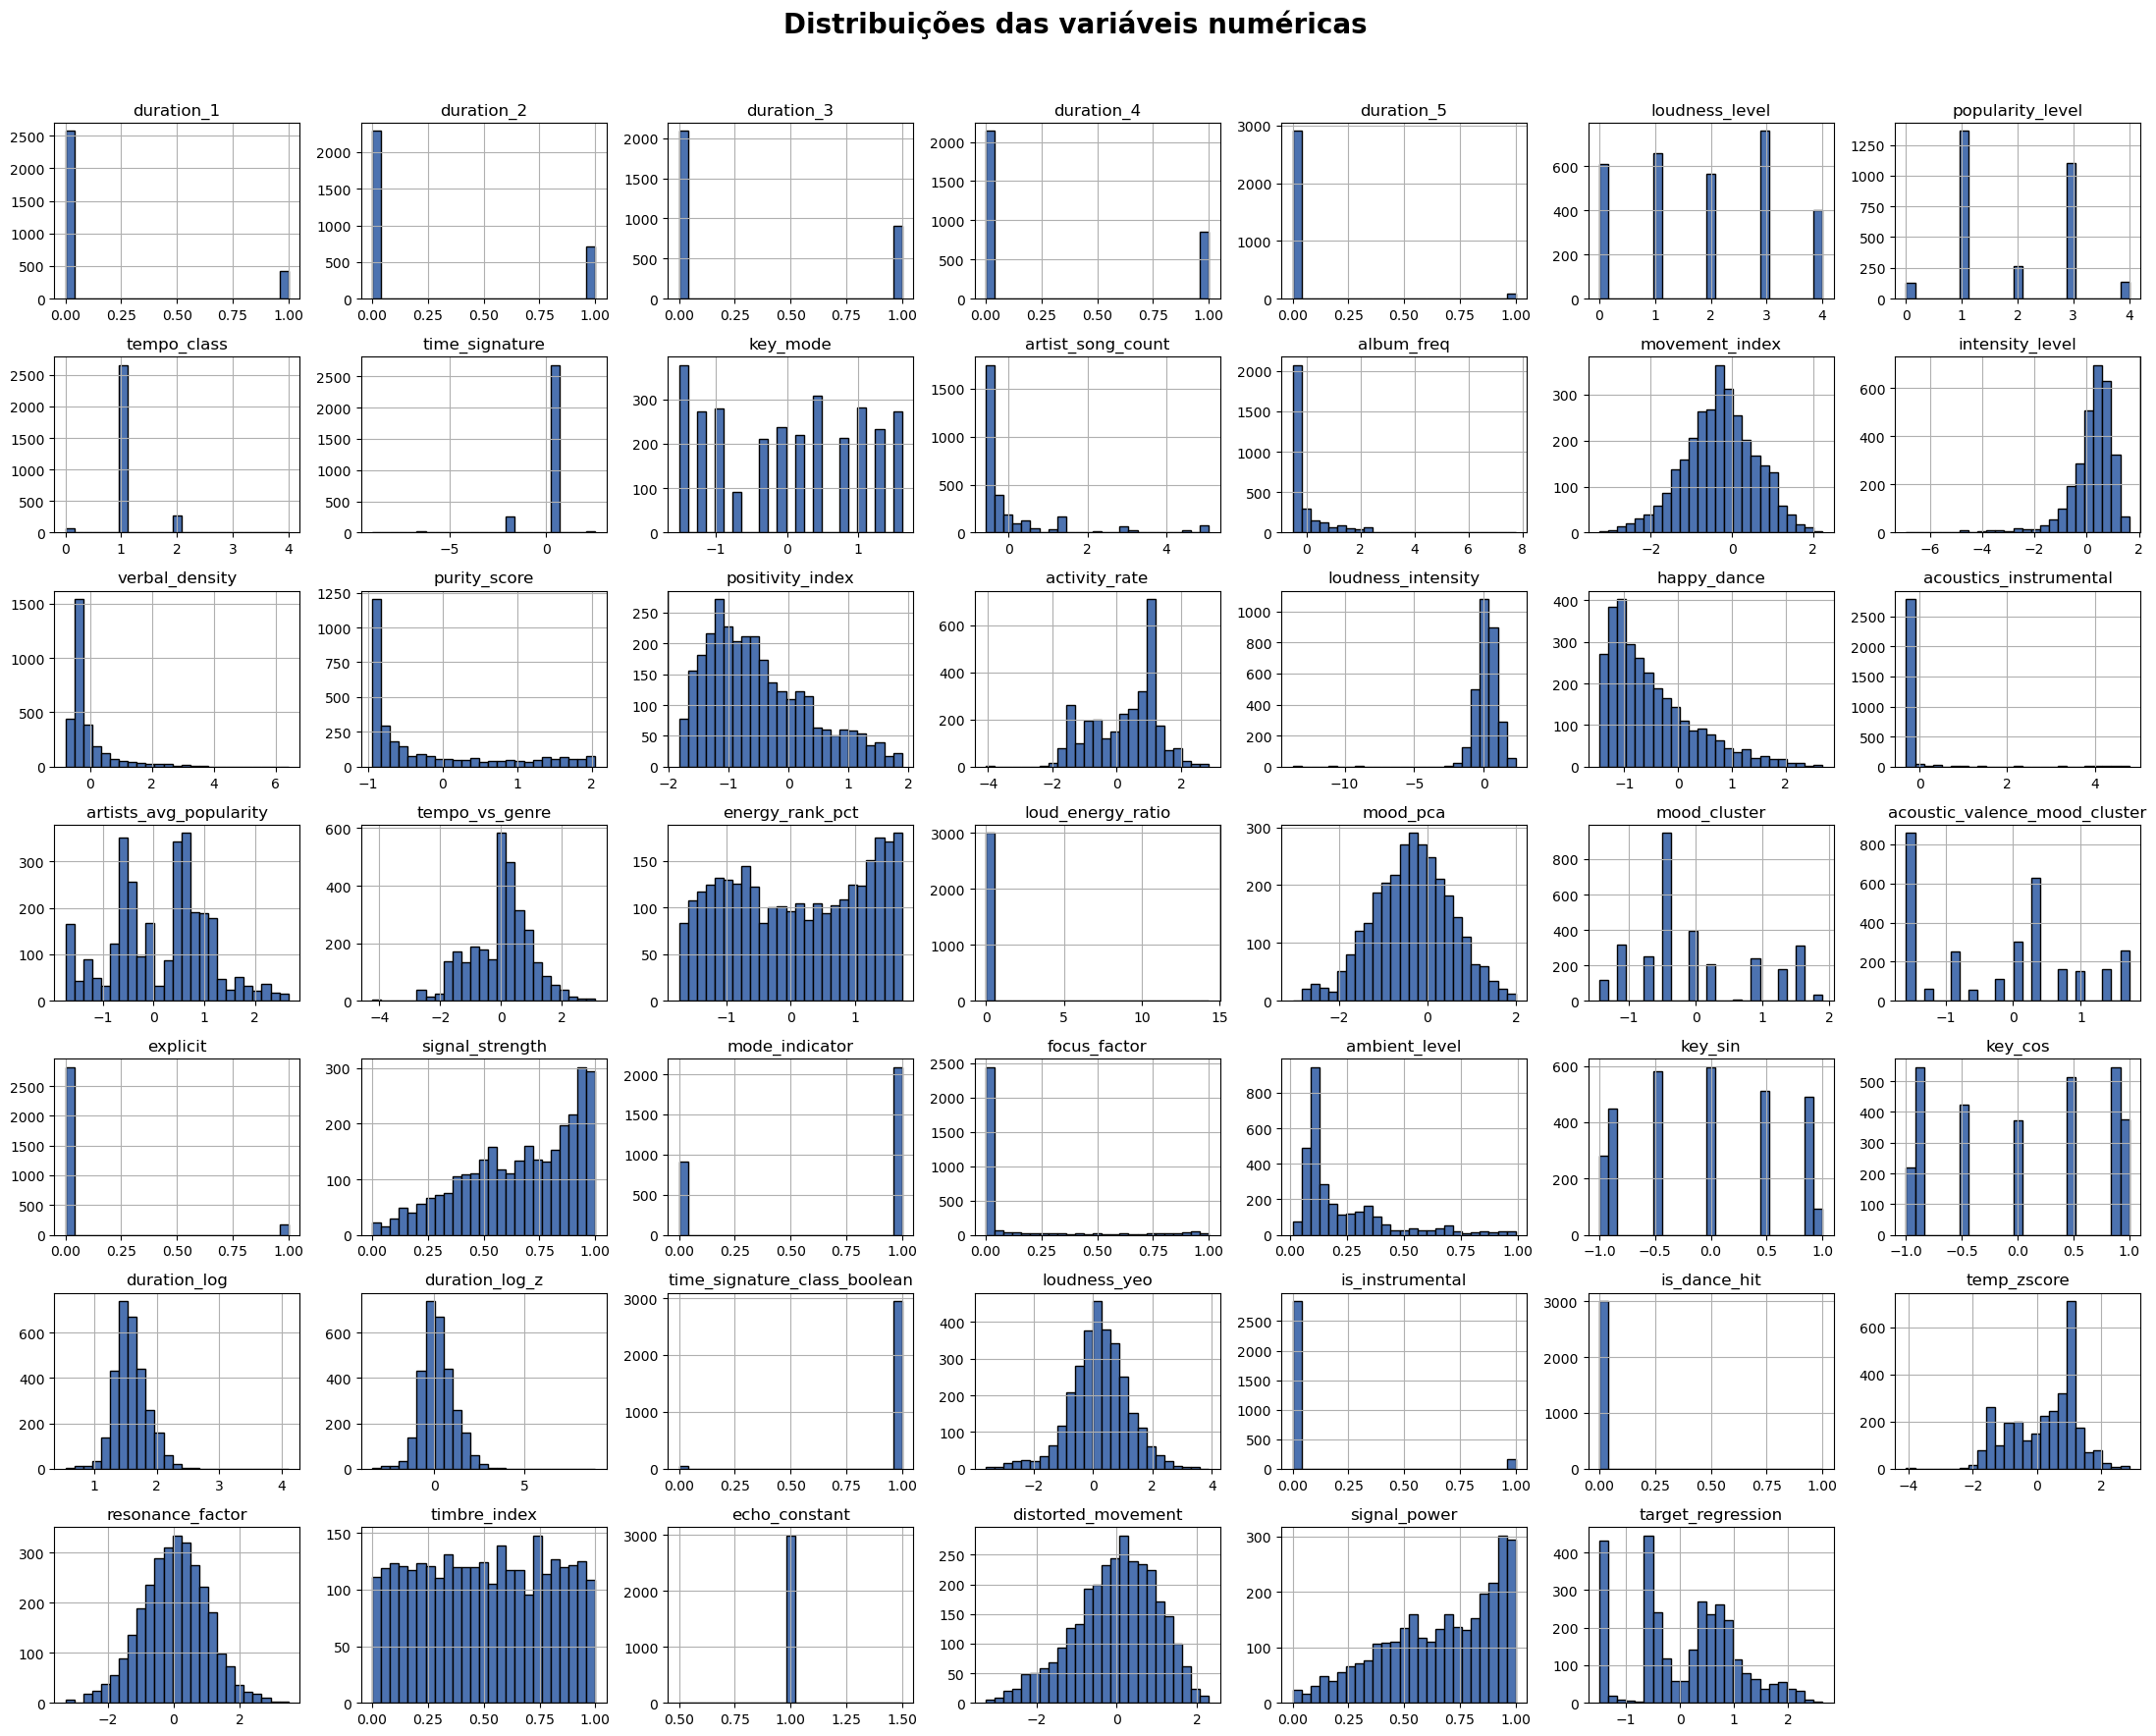

In [ ]:
# ================================================================
# Análise Exploratória de Dados (EDA) - Análise Univariada (Distribuições das variáveis numéricas)
# ================================================================

# Selecionar colunas numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Criar os histogramas num único grid
df[numeric_cols].hist(
    bins=25,                    # menos bins → curvas mais suaves
    figsize=(22, 18),           # figura grande e legível
    color='#4C72B0',            # azul consistente
    edgecolor='black'           # contorno para definição
)

plt.suptitle("Distribuições das variáveis numéricas", fontsize=20, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])  # garante que o título não sobrepõe
plt.show()


As distribuições confirmam as tendências observadas nas estatísticas descritivas: a maioria das variáveis apresenta valores centrados próximos de zero e desvio padrão inferior a 1, o que indica que os dados se encontram padronizados. Variáveis como signal_strength, signal_power e energy_rank_pct concentram-se em faixas elevadas, refletindo a predominância de níveis altos de energia e intensidade sonora. Já métricas como positivity_index e happy_dance mostram assimetria positiva, com mais observações em valores baixos. Algumas variáveis discretas, como duration_1 a duration_5, explicit e is_instrumental, exibem distribuições binárias, enquanto target_regression revela uma dispersão mais ampla, coerente com o seu papel como variável de saída contínua.

C:\Users\mjpac\AppData\Local\Temp\ipykernel_39988\1785359969.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], order=df[col].value_counts().index, ax=axes[i], palette='crest')


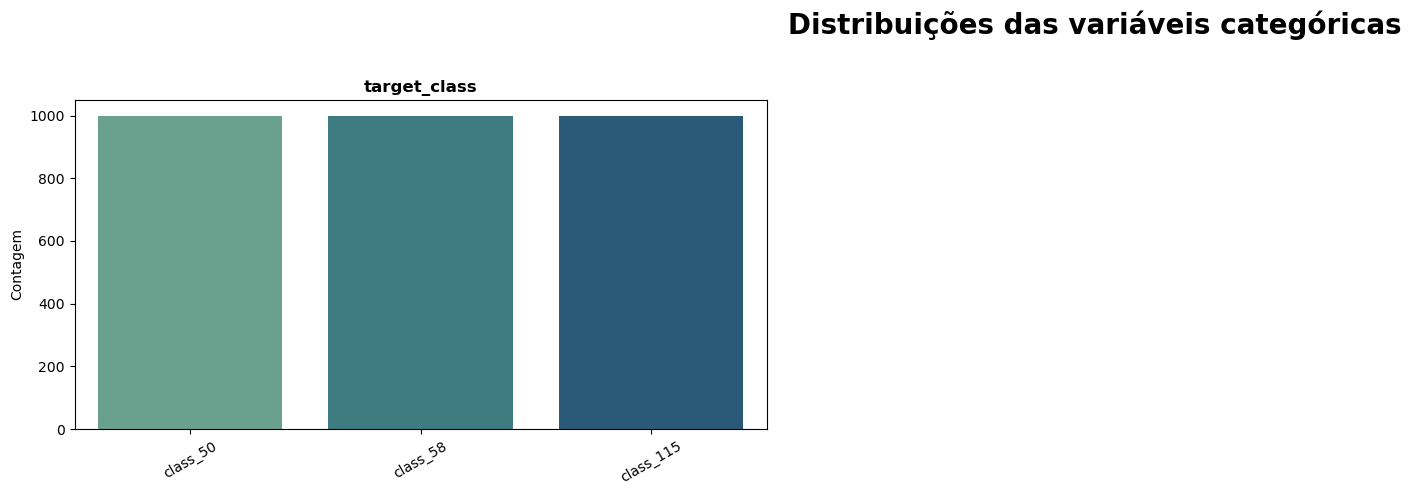

In [ ]:
# ================================================================
# Análise Exploratória de Dados (EDA) -
# Análise Univariada (Distribuições das variáveis categóricas)
# ================================================================

# Selecionar colunas categóricas
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

# Criar figura com várias subplots automaticamente
n_cols = 3  # número de gráficos por linha
n_rows = int(np.ceil(len(cat_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(22, n_rows * 5))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(x=df[col], order=df[col].value_counts().index, ax=axes[i], palette='crest')
    axes[i].set_title(col, fontsize=12, fontweight='bold')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Contagem')
    axes[i].tick_params(axis='x', rotation=30)

# Remover eixos vazios, se houver
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Distribuições das variáveis categóricas", fontsize=20, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



A variável target_class está dividida em três categorias com contagens semelhantes, demonstrando um conjunto equilibrado. Este equilíbrio é importante para evitar enviesamentos durante o treino e assegurar que os modelos de classificação aprendam de forma uniforme entre as classes.


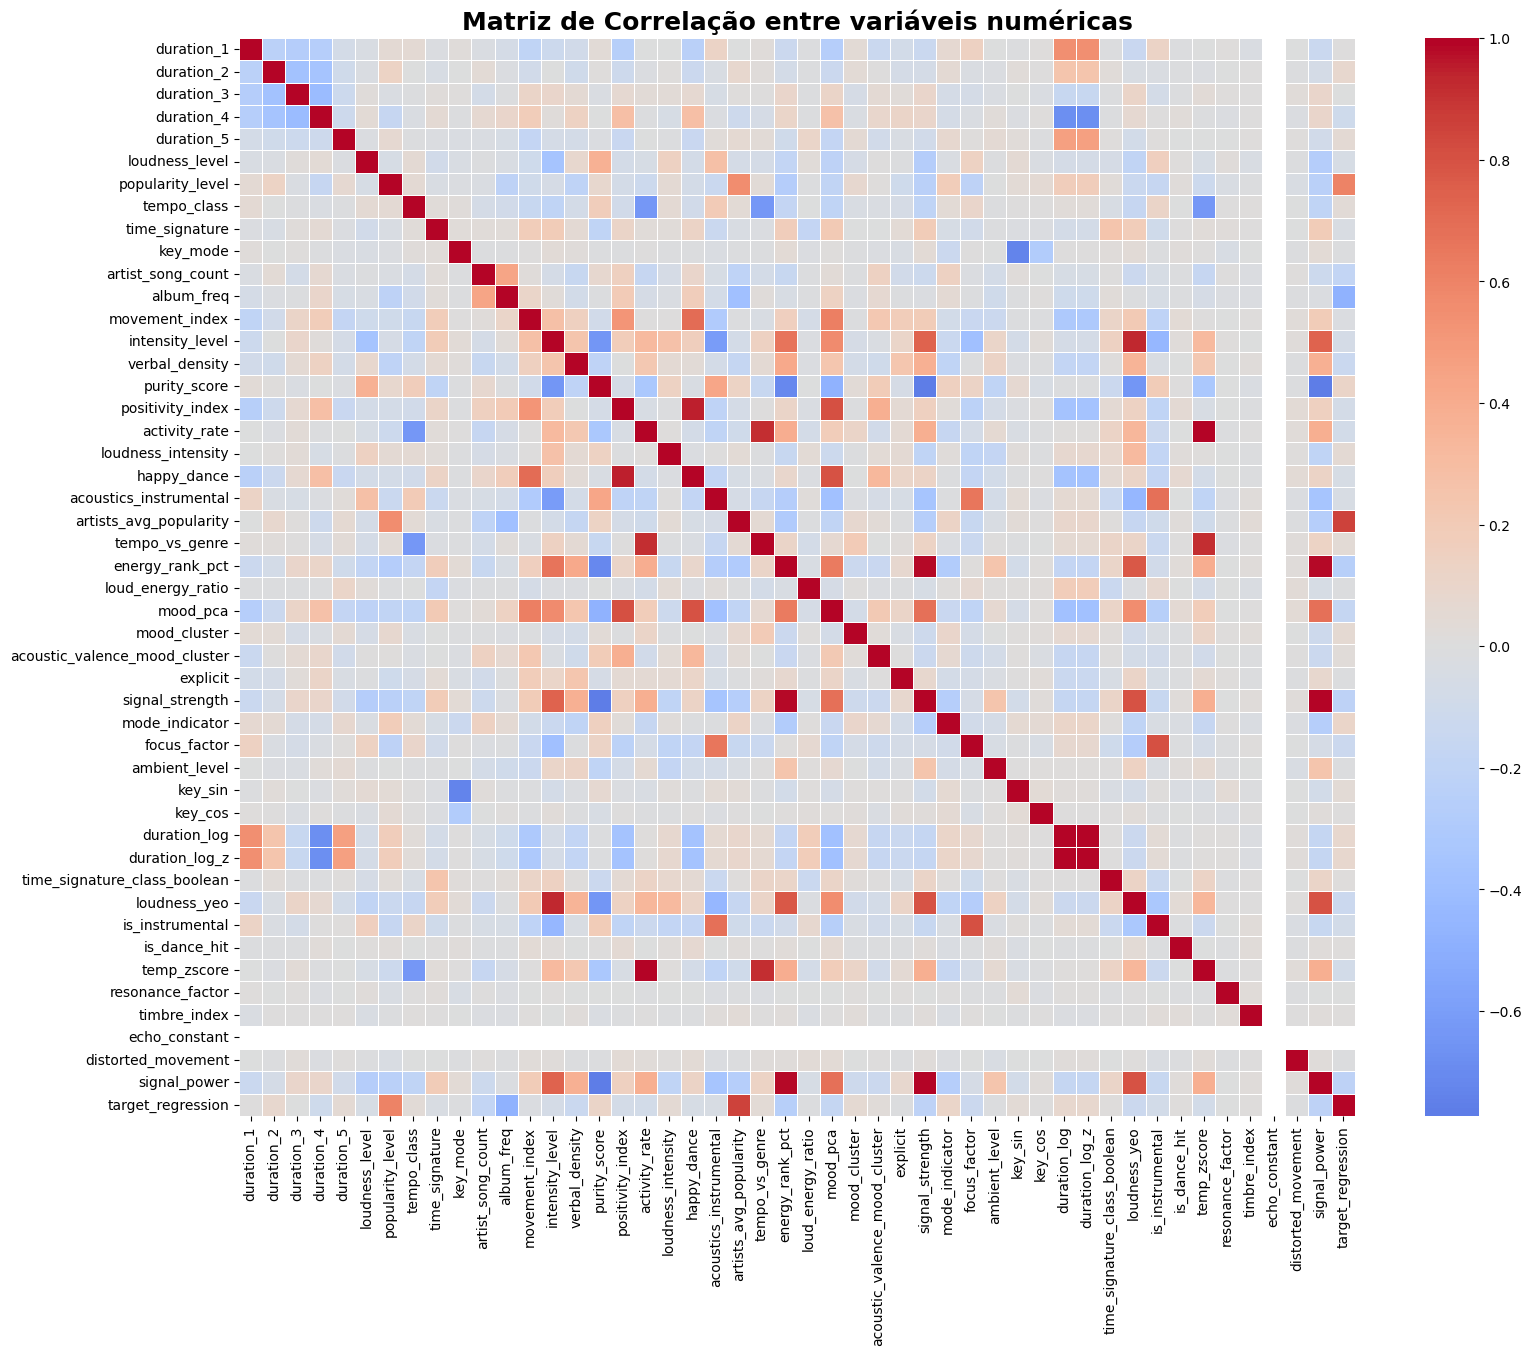

In [ ]:
# ================================================================
# EDA - Análise Bivariada
# Correlação entre features numéricas
# ================================================================

# Matriz de correlação
corr_matrix = df.corr(numeric_only=True)

# Tamanho da figura
plt.figure(figsize=(18, 14))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    center=0,
    annot=False,    #True para ver os valores
    linewidths=0.5
)
plt.title("Matriz de Correlação entre variáveis numéricas", fontsize=18, fontweight='bold')
plt.show()


Top 6 features mais correlacionadas com target_regression:


artists_avg_popularity    0.851232
popularity_level          0.598682
album_freq                0.478200
energy_rank_pct           0.249096
signal_power              0.218484
signal_strength           0.218484
Name: target_regression, dtype: float64

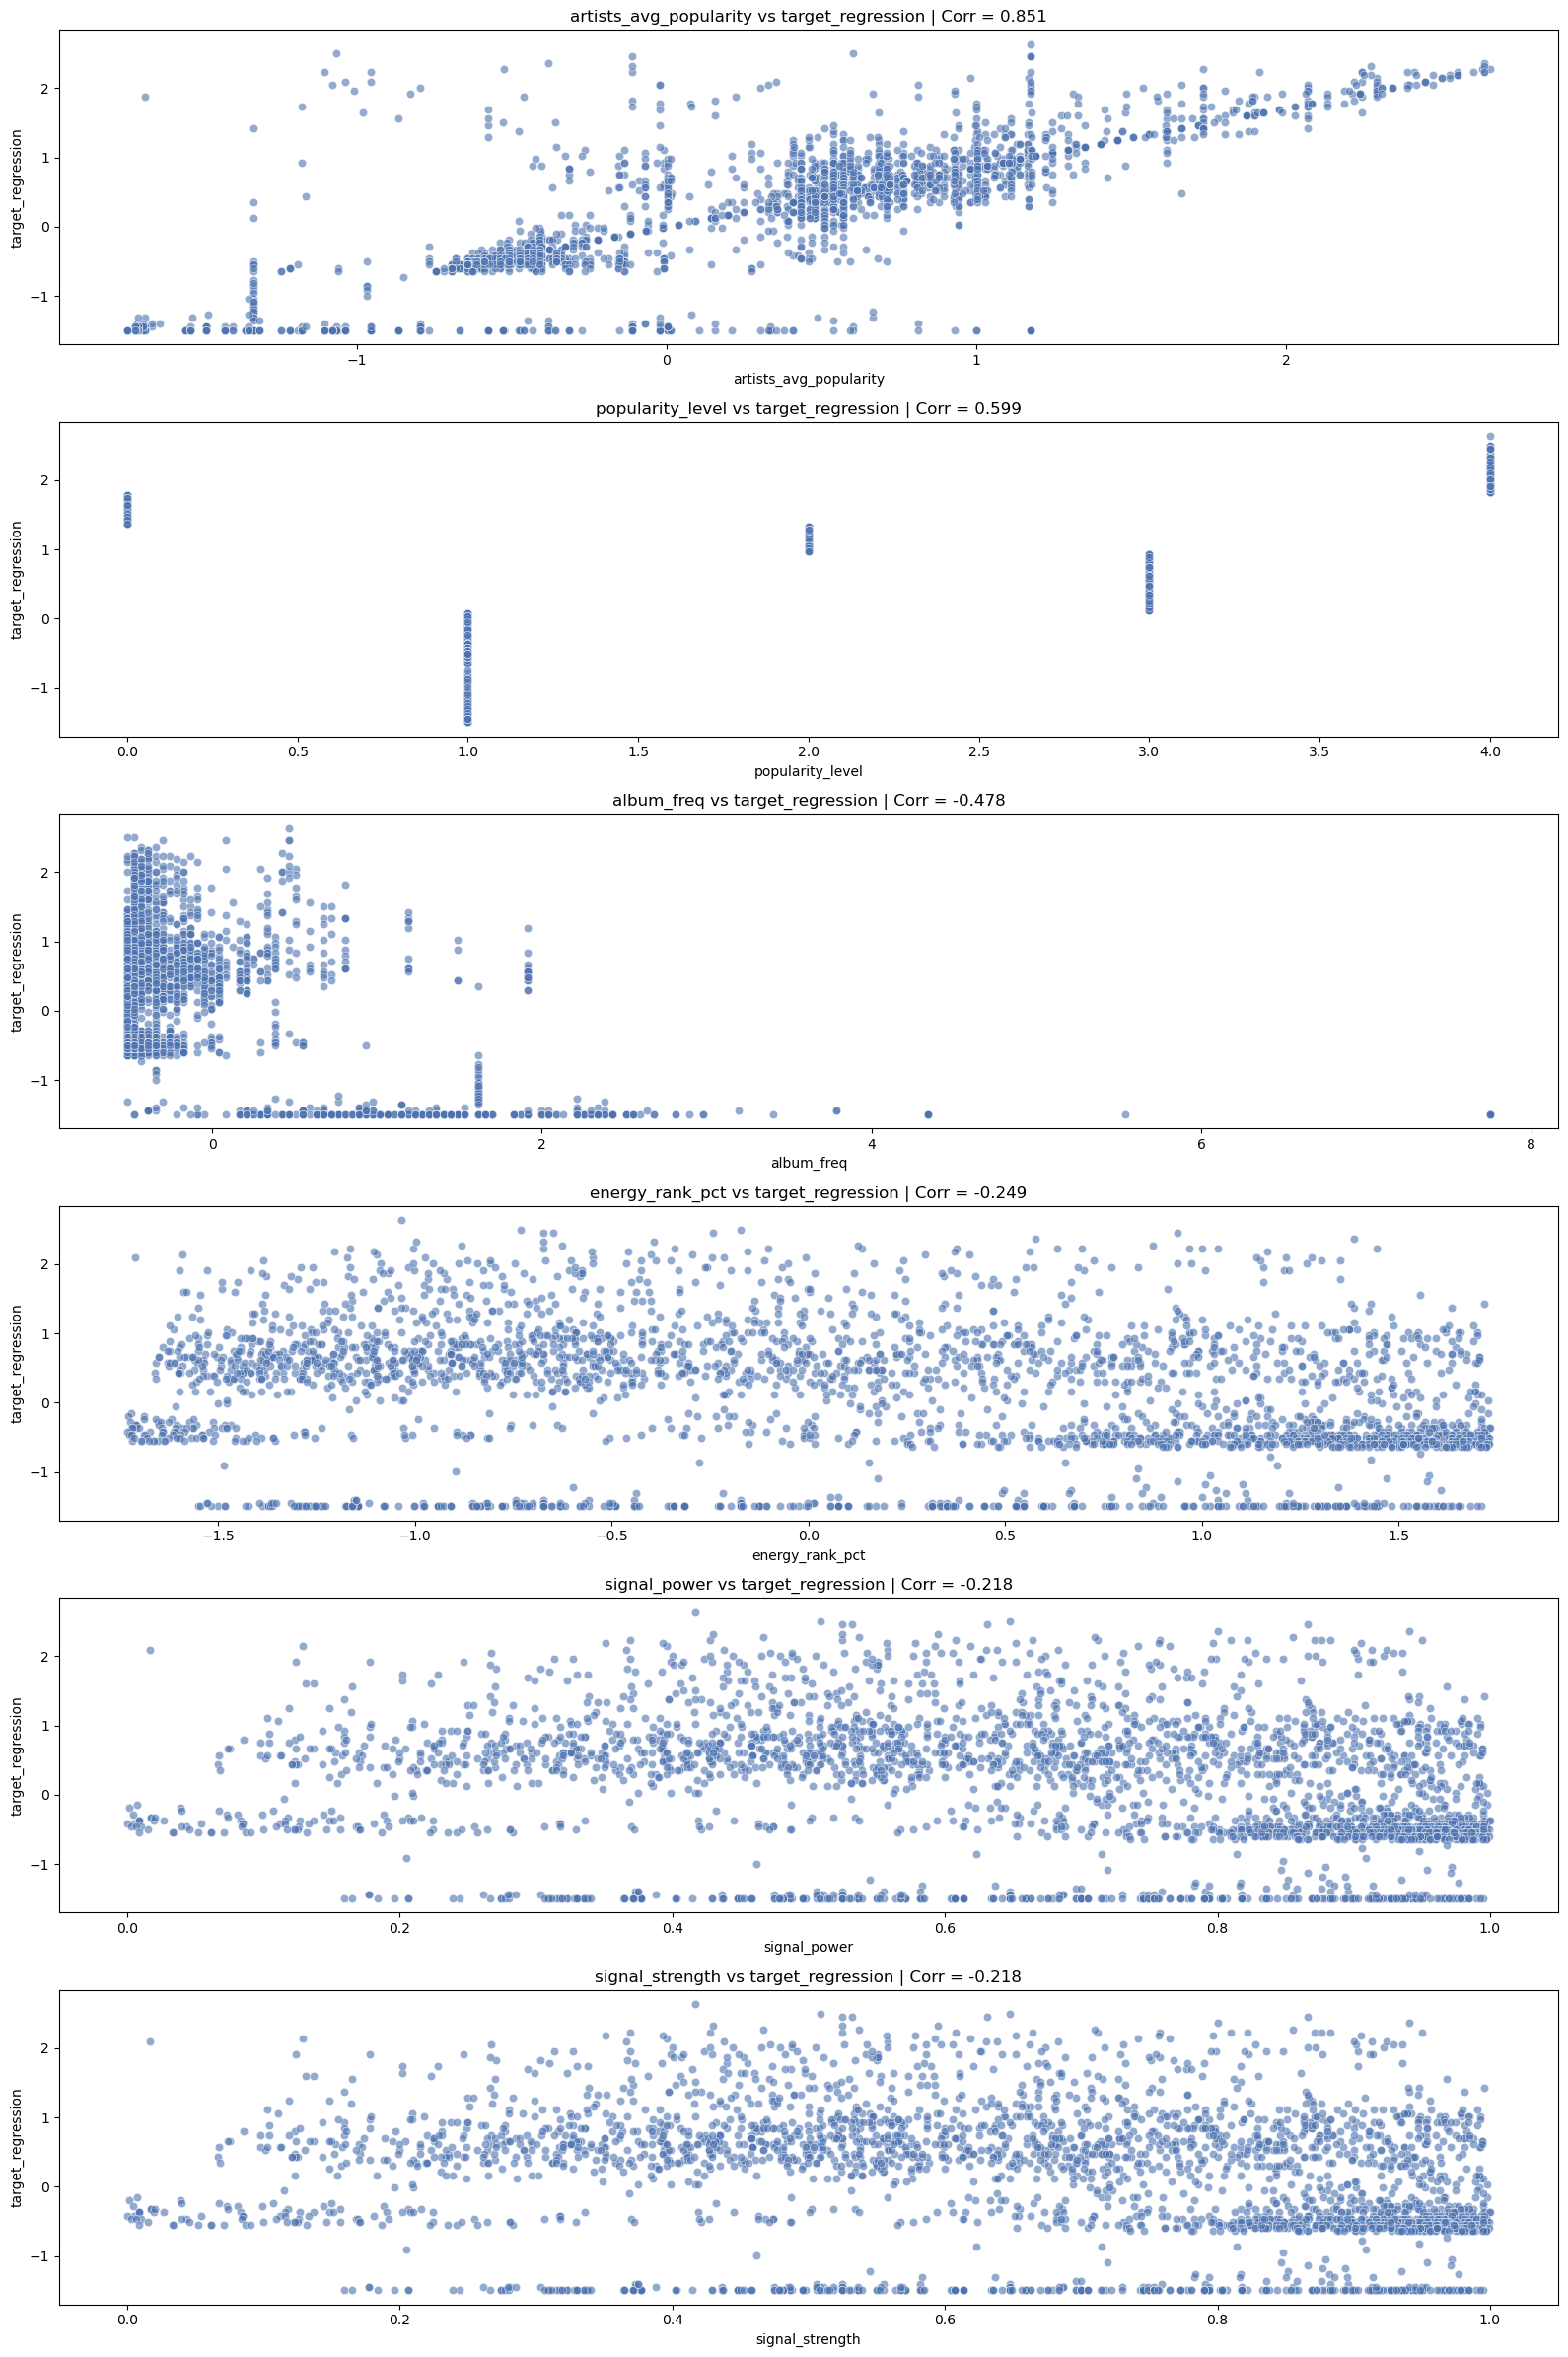

In [ ]:
################################################################################
# Análise Bivariada - Relação das features numéricas com TARGET_REGRESSION
################################################################################

TARGET_REG = "target_regression"
target_col = TARGET_REG

# Garantir que só pegamos colunas numéricas
cols_for_corr = numeric_cols.copy()
if target_col not in cols_for_corr:
    cols_for_corr.append(target_col)

# Calcular matriz de correlação
corr_matrix = df[cols_for_corr].corr()

# Obter correlação das features com o target_regression
corr_target_reg = corr_matrix[target_col].drop(target_col)  # remover o próprio target
corr_target_reg = pd.Series(corr_target_reg)

# Ordenar pelo valor absoluto (correlações mais fortes primeiro)
corr_target_reg_sorted = corr_target_reg.abs().sort_values(ascending=False)

# Definir quantas features mostrar
top_n = 6
top_features = corr_target_reg_sorted.head(top_n).index.tolist()

print(f"Top {top_n} features mais correlacionadas com {TARGET_REG}:")
display(corr_target_reg_sorted.head(top_n))

################################################################################
# Gráficos de dispersão entre as features mais correlacionadas e o target
################################################################################

plt.figure(figsize=(16, 4 * top_n))
for i, feat in enumerate(top_features):
    plt.subplot(top_n, 1, i + 1)
    sns.scatterplot(x=df[feat], y=df[target_col], alpha=0.6, color='#4C72B0')
    plt.xlabel(feat)
    plt.ylabel(target_col)
    plt.title(f"{feat} vs {target_col} | Corr = {corr_matrix.loc[feat, target_col]:.3f}")
plt.tight_layout()
plt.show()


Observa-se correlação forte entre target_regression e variáveis de popularidade (artists_avg_popularity, popularity_level, album_freq), indicando que a notoriedade dos artistas é o principal fator explicativo do desempenho musical.
As métricas de energia e intensidade sonora (energy_rank_pct, signal_power, signal_strength) apresentam correlações mais fracas e dispersas, sugerindo que influenciam o resultado de forma secundária.
Nota-se ainda que album_freq tende a ter uma relação inversa com o alvo, o que pode refletir que artistas com lançamentos muito frequentes nem sempre atingem maior impacto individual por faixa.


Top 6 features mais correlacionadas com target_class:


movement_index      0.464022
happy_dance         0.435895
duration_log        0.408436
duration_log_z      0.408436
positivity_index    0.404902
mood_pca            0.363819
Name: target_class, dtype: float64

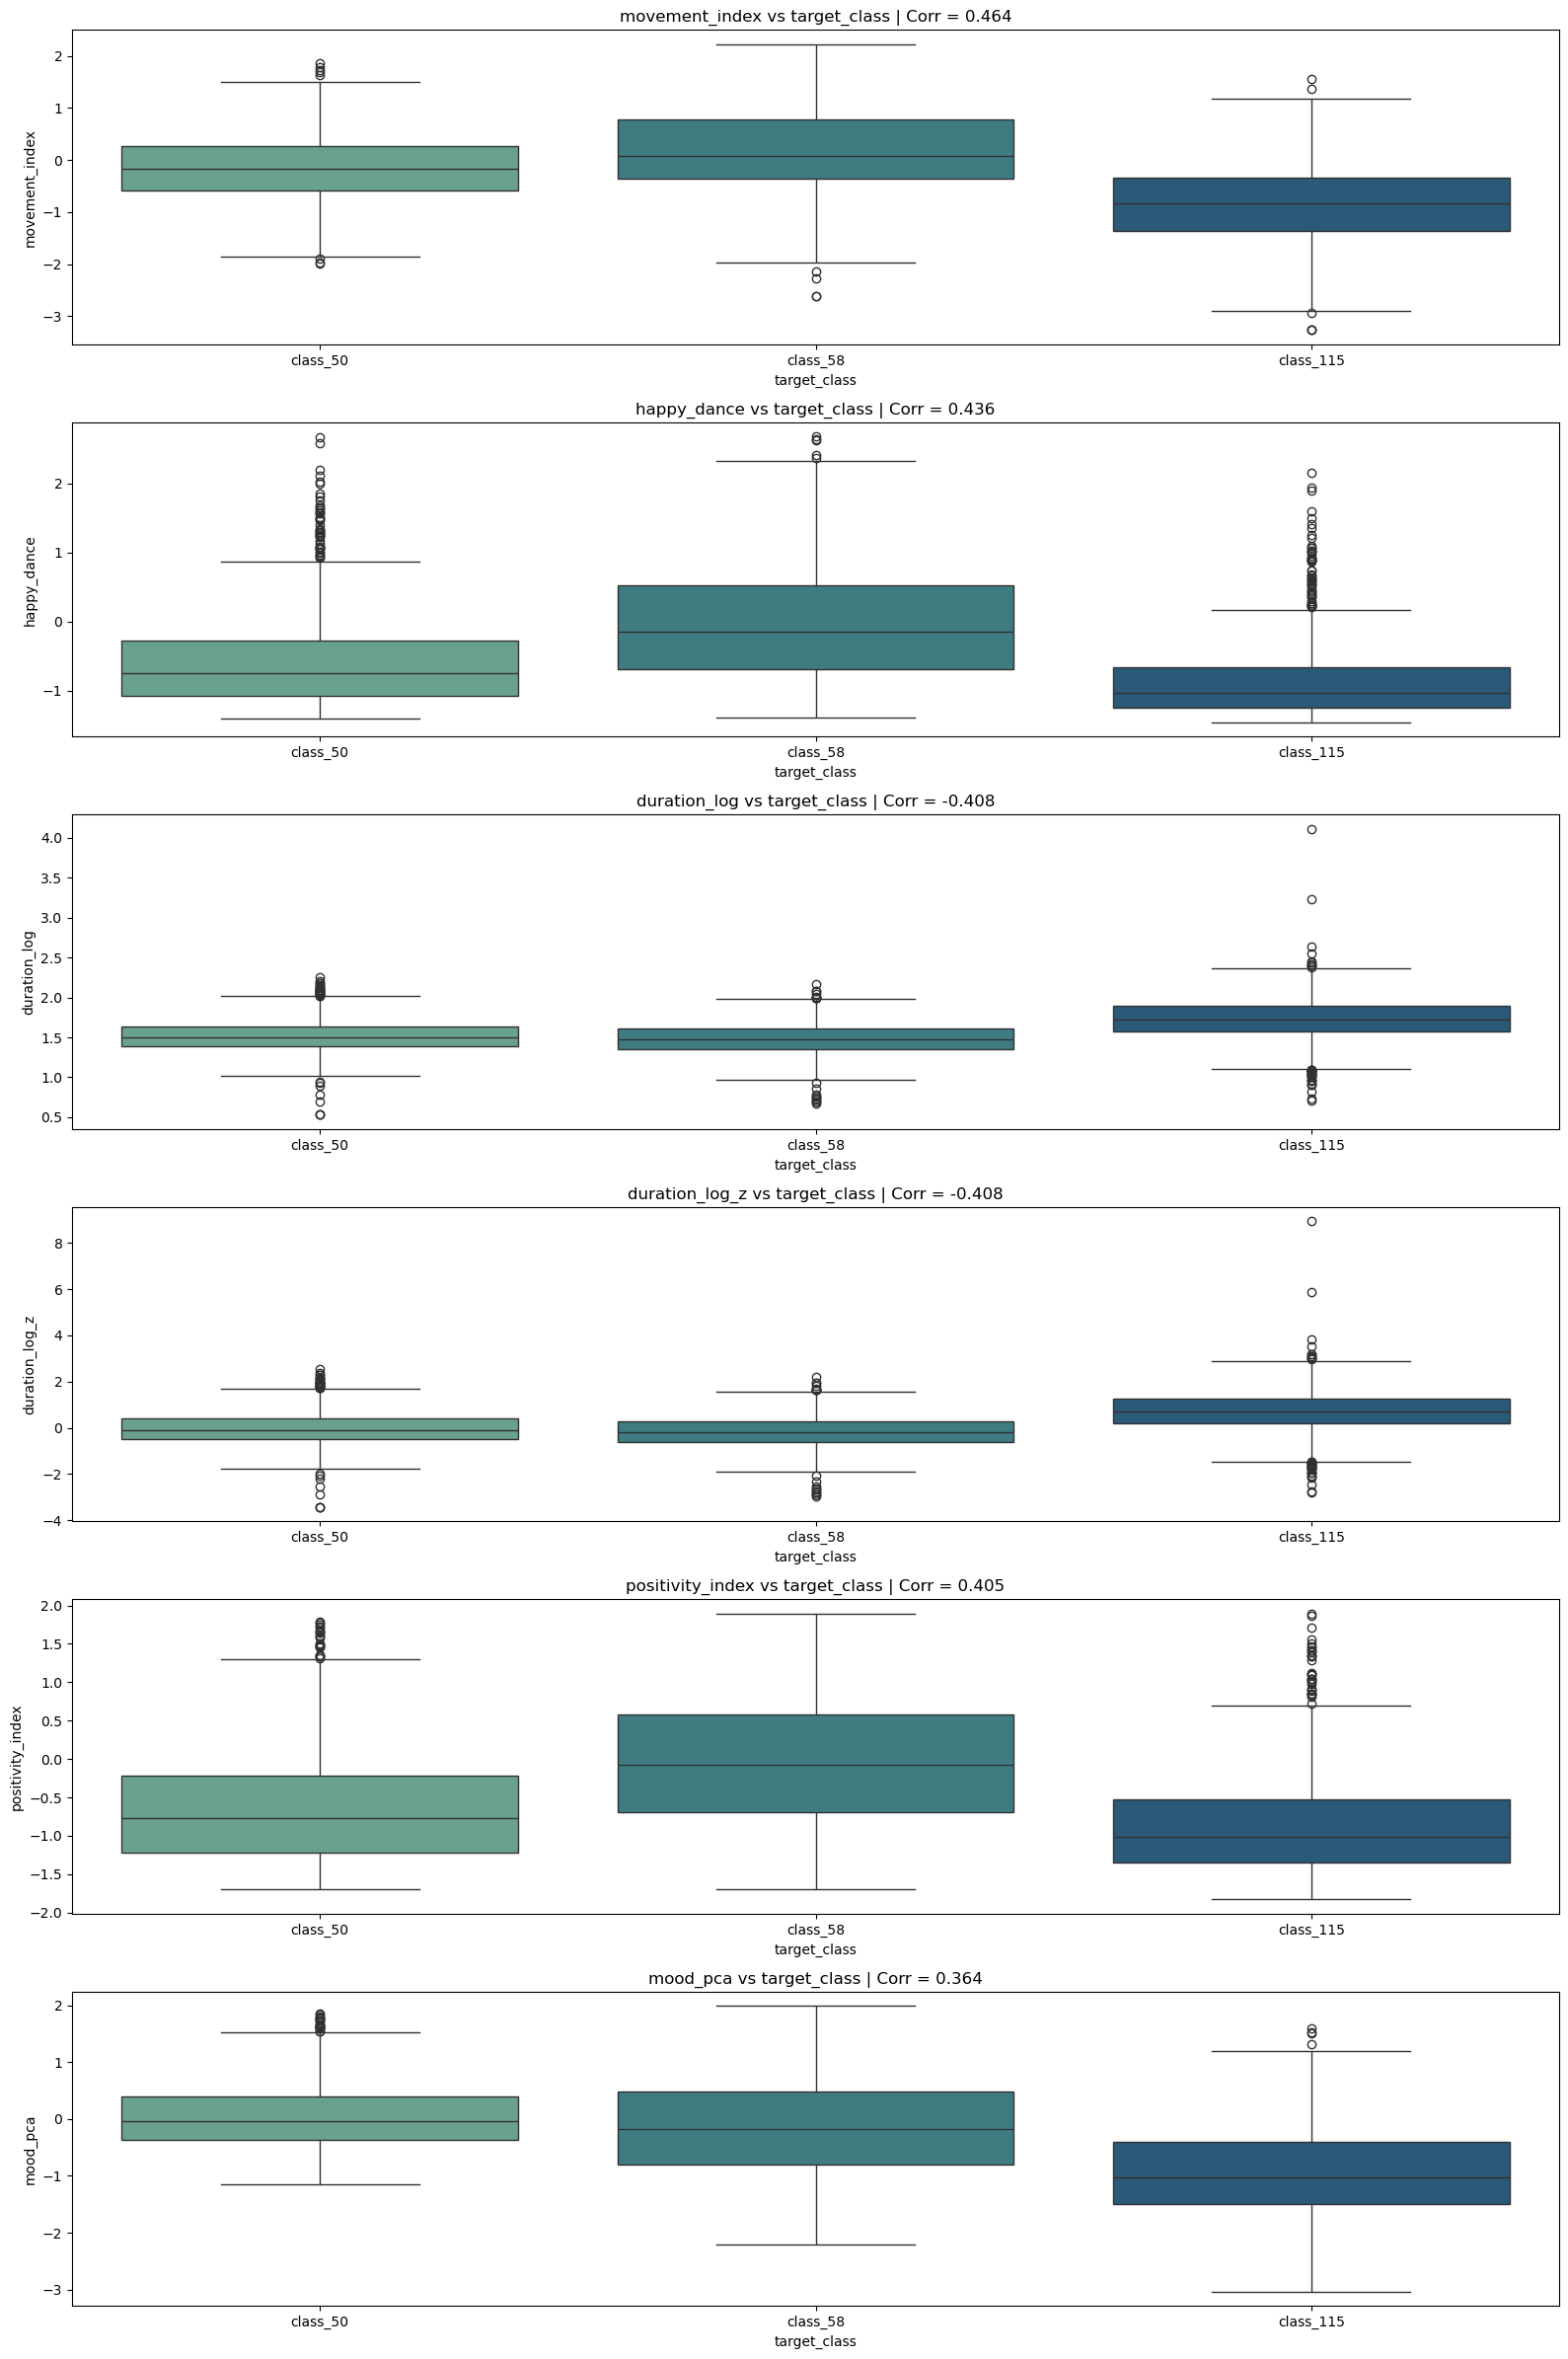

In [ ]:
################################################################################
# Análise Bivariada - Relação das features numéricas com TARGET_CLASS
################################################################################

TARGET_CLASS = "target_class"
target_col = TARGET_CLASS

# Garantir que só pegamos colunas numéricas
cols_for_corr = numeric_cols.copy()

# Copiar o dataframe e converter temporariamente as classes em valores numéricos
df_temp = df.copy()
df_temp[target_col] = df_temp[target_col].astype("category").cat.codes  # converte classes para 0, 1, 2, ...

# Calcular matriz de correlação
corr_matrix_class = df_temp[cols_for_corr + [target_col]].corr()

# Obter correlação das features com o target_class
corr_target_class = corr_matrix_class[target_col].drop(target_col)  # remover o próprio target
corr_target_class = pd.Series(corr_target_class)

# Ordenar pelo valor absoluto (correlações mais fortes primeiro)
corr_target_class_sorted = corr_target_class.abs().sort_values(ascending=False)

# Definir quantas features mostrar
top_n = 6
top_features_class = corr_target_class_sorted.head(top_n).index.tolist()

print(f"Top {top_n} features mais correlacionadas com {TARGET_CLASS}:")
display(corr_target_class_sorted.head(top_n))

################################################################################
# Gráficos de distribuição das top features por classe
################################################################################

plt.figure(figsize=(16, 4 * top_n))
for i, feat in enumerate(top_features_class):
    plt.subplot(top_n, 1, i + 1)
    sns.boxplot(x=df[target_col], y=df[feat], hue=df[target_col], palette="crest", legend=False)
    plt.xlabel(target_col)
    plt.ylabel(feat)
    plt.title(f"{feat} vs {target_col} | Corr = {corr_matrix_class.loc[feat, target_col]:.3f}")
plt.tight_layout()
plt.show()



,Min,Max,Amplitude
loudness_intensity,-13.743739,2.298788,16.042527
loud_energy_ratio,-0.009682,14.291468,14.301150
duration_log_z,-3.428544,8.930866,12.359410
time_signature,-9.024149,2.533318,11.557467
intensity_level,-6.916232,1.623664,8.539896
album_freq,-0.514901,7.751164,8.266065
loudness_yeo,-3.602446,3.894016,7.496461
tempo_vs_genre,-4.233564,3.099539,7.333103
verbal_density,-0.800628,6.415707,7.216335
activity_rate,-4.074556,2.862828,6.937384


C:\Users\mjpac\AppData\Local\Temp\ipykernel_39988\3424793991.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=amplitude_df.index, y=amplitude_df['Amplitude'], palette='crest')


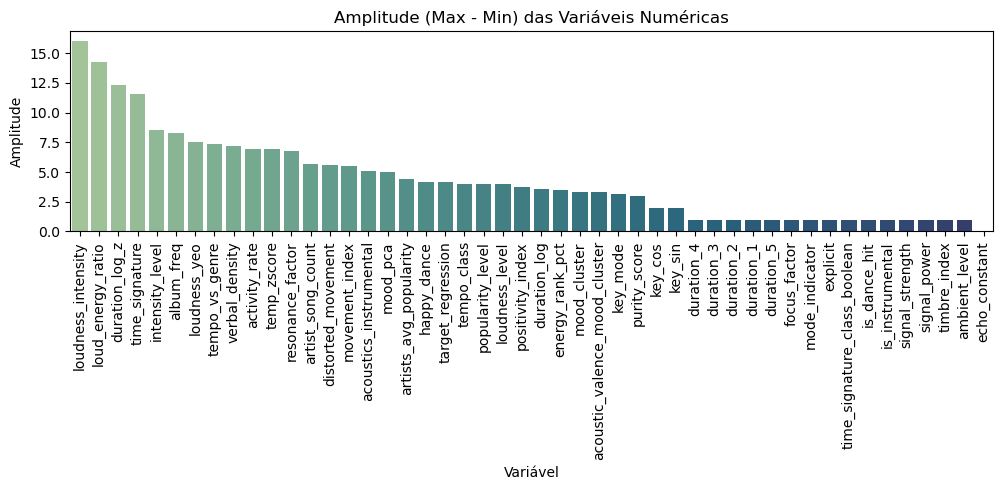

In [ ]:
# ================================================================
# Análise das Variáveis Numéricas
# ================================================================

# Selecionar apenas colunas numéricas
num_cols = df.select_dtypes(include=[np.number]).columns

# Calcular amplitude = max - min
amplitude = df[num_cols].max() - df[num_cols].min()

# Organizar em DataFrame
amplitude_df = pd.DataFrame({
    'Min': df[num_cols].min(),
    'Max': df[num_cols].max(),
    'Amplitude': amplitude
}).sort_values(by='Amplitude', ascending=False)

# Exibir tabela ordenada por amplitude (maiores primeiro)
display(amplitude_df.head(15))

# Visualização opcional para ter noção das diferenças de escala
plt.figure(figsize=(10,5))
sns.barplot(x=amplitude_df.index, y=amplitude_df['Amplitude'], palette='crest')
plt.xticks(rotation=90)
plt.title("Amplitude (Max - Min) das Variáveis Numéricas")
plt.ylabel("Amplitude")
plt.xlabel("Variável")
plt.tight_layout()
plt.show()


A análise das amplitudes evidencia diferenças acentuadas entre as escalas das variáveis numéricas. Algumas métricas, como loudness_intensity, duration_log_z e time_signature, apresentam amplitudes superiores a 10 unidades, indicando ausência de normalização prévia e elevada variabilidade. Por outro lado, várias variáveis já se encontram limitadas ao intervalo [0, 1], o que demonstra um conjunto misto de escalas.
Assim, a aplicação de normalização seletiva às variáveis contínuas de maior amplitude é recomendável para equilibrar a influência de cada preditor nos modelos lineares e garantir maior estabilidade nos resultados.

Observa-se que artists_avg_popularity e popularity_level apresentam forte relação com target_regression, evidenciando que a notoriedade e o alcance dos artistas são fatores determinantes para o sucesso das faixas. Já variáveis como movement_index, happy_dance e positivity_index diferenciam claramente as classes, sugerindo que o ritmo, a energia e o tom emocional desempenham um papel relevante na categorização dos níveis de impacto musical.

In [ ]:
################################################################################
# Top 6 pares de variáveis mais correlacionadas entre si
################################################################################

# Calcular matriz de correlação das variáveis numéricas
numeric_df = df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr().round(3)

# Transformar em tabela longa (pares)
corr_pairs = (
    corr_matrix.unstack()               # transforma matriz em série (pares)
    .reset_index()                      # vira DataFrame
    .rename(columns={'level_0': 'Feature_1', 'level_1': 'Feature_2', 0: 'Correlation'})
)

# Remover autocorrelações e duplicados (A–B igual a B–A)
corr_pairs = corr_pairs[corr_pairs['Feature_1'] != corr_pairs['Feature_2']]
corr_pairs['abs_corr'] = corr_pairs['Correlation'].abs()
corr_pairs = corr_pairs.sort_values(by='abs_corr', ascending=False)

# Remover duplicados (manter apenas um por par)
corr_pairs = corr_pairs.drop_duplicates(subset=['abs_corr'])

# Selecionar top 6
top6_corr = corr_pairs.head(6).reset_index(drop=True)

# Mostrar resultado
print("Top 6 correlações entre variáveis numéricas:")
display(top6_corr[['Feature_1', 'Feature_2', 'Correlation']])


Top 6 correlações entre variáveis numéricas:


,Feature_1,Feature_2,Correlation
0,signal_power,signal_strength,1.000
1,signal_strength,energy_rank_pct,0.982
2,happy_dance,positivity_index,0.946
3,loudness_yeo,intensity_level,0.927
4,tempo_vs_genre,activity_rate,0.913
5,artists_avg_popularity,target_regression,0.851


## REGRESSÃO

Foram implementados e comparados modelos supervisionados de **Regressão Linear**, aplicados à variável-alvo contínua `target_regression`.  
O objetivo foi avaliar a relação entre as variáveis explicativas e o valor previsto, identificando os principais preditores associados à popularidade das faixas.

A abordagem iniciou-se com a **Regressão Linear Simples**, onde cada variável numérica foi testada individualmente, evoluindo depois para a **Regressão Linear Múltipla**, que considera o efeito conjunto das variáveis.  

Todos os modelos foram treinados após a **normalização das features numéricas** (`StandardScaler`) e utilizando o método **Hold-out (70/30)** para a divisão entre treino e teste, garantindo uma avaliação consistente do desempenho preditivo.


Identificamos correlações muito elevadas entre variáveis com significado semelhante (signal_strength–signal_power, positivity_index–happy_dance), o que indica redundância. A relação entre artists_avg_popularity e target_regression confirma a relevância da popularidade dos artistas. Optamos por aplicar regularização e considerar a remoção de variáveis redundantes para minimizar a multicolinearidade nos modelos.


In [ ]:
################################################################################
# 3. Preparação de Features e Variáveis target (df e df_clean)
################################################################################

def preparar_dados(data, label):
    print(f"\n=== Dataset: {label} ===")
    TARGET_REG = 'target_regression'
    TARGET_CLASS = 'target_class'

    y_class = data[TARGET_CLASS].astype('category')
    y_class_codes = y_class.cat.codes
    class_labels = y_class.cat.categories.tolist()

    X = data.drop(columns=[TARGET_REG, TARGET_CLASS]).copy()
    y_reg = data[TARGET_REG]

    X = X.fillna(X.median(numeric_only=True))

    print(f"Features numéricas selecionadas: {X.shape[1]}")
    print(f"Dimensões de X: {X.shape}, y_reg: {y_reg.shape}, y_class: {y_class.shape}")
    return X, y_reg

X, y_reg = preparar_dados(df, "Original")
X_clean, y_reg_clean = preparar_dados(df_clean, "Sem Outliers")



=== Dataset: Original ===
Features numéricas selecionadas: 47
Dimensões de X: (2999, 47), y_reg: (2999,), y_class: (2999,)

=== Dataset: Sem Outliers ===
Features numéricas selecionadas: 47
Dimensões de X: (532, 47), y_reg: (532,), y_class: (532,)


In [ ]:
# ================================================================
# 4. Split Treino/Teste e Normalização para Regressão (df e df_clean)
# ================================================================

def split_normalizar(X, y, label):
    print(f"\n=== {label} ===")

    # Converter vírgulas decimais para pontos e garantir formato numérico
    X = X.apply(lambda col: col.astype(str).str.replace(',', '.'))
    X = X.apply(pd.to_numeric, errors='coerce')
    X = X.fillna(X.median(numeric_only=True))

    # Hold-out split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    # Normalização
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)

    print(f"Train shapes → X: {X_train.shape}, y: {y_train.shape}")
    print(f"Test  shapes → X: {X_test.shape}, y: {y_test.shape}")

    print("\nMédias e desvios padrão após normalização:")
    print(f"Média treino: {X_train_s.mean():.4f}   | Desvio treino: {X_train_s.std():.4f}")
    print(f"Média teste:  {X_test_s.mean():.4f}   | Desvio teste:  {X_test_s.std():.4f}")

    # Converter novamente para DataFrame
    X_train_s = pd.DataFrame(X_train_s, columns=X_train.columns)
    X_test_s  = pd.DataFrame(X_test_s,  columns=X_test.columns)

    return X_train_s, X_test_s, y_train, y_test


# Executar para os dois datasets
X_train_s, X_test_s, y_train, y_test = split_normalizar(X, y_reg, "Original")
Xc_train_s, Xc_test_s, yc_train, yc_test = split_normalizar(X_clean, y_reg_clean, "Sem Outliers")



=== Original ===
Train shapes → X: (2099, 47), y: (2099,)
Test  shapes → X: (900, 47), y: (900,)

Médias e desvios padrão após normalização:
Média treino: -0.0000   | Desvio treino: 0.9893
Média teste:  -0.0030   | Desvio teste:  0.9477

=== Sem Outliers ===
Train shapes → X: (372, 47), y: (372,)
Test  shapes → X: (160, 47), y: (160,)

Médias e desvios padrão após normalização:
Média treino: -0.0000   | Desvio treino: 0.8873
Média teste:  -0.0095   | Desvio teste:  0.8756


A divisão treino/teste e a normalização foram bem-sucedidas: as médias próximas de zero e desvios padrão unitários confirmam que as variáveis estão padronizadas, assegurando equilíbrio entre as 47 features numéricas nos modelos lineares.


In [ ]:
################################################################################
# Simple Linear Regression (Hold-out) – df e df_clean
################################################################################

def regressao_simples(X_train_s, X_test_s, y_train, y_test, label):
    print(f"\n=== Regressão Linear Simples – {label} ===")

    best_feat = None
    best_r2   = -np.inf
    simple_results = []

    # Treinar um modelo simples (1 feature por vez)
    for feat in X_train_s.columns:
        lr = LinearRegression()
        lr.fit(X_train_s[[feat]], y_train)
        y_pred = lr.predict(X_test_s[[feat]])

        # Métricas
        r2   = r2_score(y_test, y_pred)
        mse  = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae  = mean_absolute_error(y_test, y_pred)

        simple_results.append((feat, r2, rmse, mae))

        if r2 > best_r2:
            best_feat = feat
            best_r2 = r2

    # Ranking das melhores features
    results_df = (
        pd.DataFrame(simple_results, columns=['Feature', 'R²', 'RMSE', 'MAE'])
        .sort_values('R²', ascending=False)
        .reset_index(drop=True)
    )

    display(results_df.head(10))
    print(f"\nMelhor feature ({label}): {best_feat} | R² = {best_r2:.3f}")

    # Modelo final com a melhor feature
    lr_best = LinearRegression()
    lr_best.fit(X_train_s[[best_feat]], y_train)
    y_pred_best = lr_best.predict(X_test_s[[best_feat]])

    # Métricas do melhor modelo
    mse_best = mean_squared_error(y_test, y_pred_best)
    metrics_simple = {
        'R²':   r2_score(y_test, y_pred_best),
        'RMSE': np.sqrt(mse_best),
        'MAE':  mean_absolute_error(y_test, y_pred_best)
    }

    print("\nDesempenho do melhor modelo simples:")
    for k, v in metrics_simple.items():
        print(f"{k}: {v:.4f}")

    return results_df, best_feat, metrics_simple, y_pred_best, lr_best



# Executar para ambos os datasets
res_df, best_feat, metrics_df, y_pred_best, lr_best = regressao_simples(X_train_s, X_test_s, y_train, y_test, "Original")
res_df_clean, best_feat_clean, metrics_df_clean, y_pred_best_clean, lr_best_clean = regressao_simples(Xc_train_s, Xc_test_s, yc_train, yc_test, "Sem Outliers")


################################################################################
# Comparação entre os dois resultados
################################################################################
comparison = pd.DataFrame([
    {
        "Dataset": "Original",
        "Melhor Feature": best_feat,
        **metrics_df
    },
    {
        "Dataset": "Sem Outliers",
        "Melhor Feature": best_feat_clean,
        **metrics_df_clean
    }
])

display(comparison)



=== Regressão Linear Simples – Original ===


,Feature,R²,RMSE,MAE
0,artists_avg_popularity,0.702619,0.518091,0.265195
1,popularity_level,0.391428,0.741150,0.498189
2,album_freq,0.214592,0.841972,0.701489
3,energy_rank_pct,0.059739,0.921243,0.721888
4,signal_strength,0.047091,0.927418,0.742323
5,signal_power,0.047091,0.927418,0.742323
6,artist_song_count,0.033244,0.934132,0.793878
7,mood_pca,0.029121,0.936122,0.767708
8,verbal_density,0.026780,0.937250,0.766090
9,loudness_yeo,0.019156,0.940914,0.777029



Melhor feature (Original): artists_avg_popularity | R² = 0.703

Desempenho do melhor modelo simples:
R²: 0.7026
RMSE: 0.5181
MAE: 0.2652

=== Regressão Linear Simples – Sem Outliers ===


,Feature,R²,RMSE,MAE
0,artists_avg_popularity,0.573794,0.567214,0.294609
1,popularity_level,0.300816,0.726495,0.506206
2,activity_rate,0.076642,0.834876,0.677565
3,temp_zscore,0.076642,0.834876,0.677565
4,album_freq,0.051135,0.846329,0.718292
5,verbal_density,0.047975,0.847737,0.701172
6,ambient_level,0.022418,0.859041,0.693349
7,positivity_index,0.009225,0.864818,0.725632
8,happy_dance,0.008458,0.865152,0.725081
9,distorted_movement,0.006363,0.866066,0.726864



Melhor feature (Sem Outliers): artists_avg_popularity | R² = 0.574

Desempenho do melhor modelo simples:
R²: 0.5738
RMSE: 0.5672
MAE: 0.2946


,Dataset,Melhor Feature,R²,RMSE,MAE
0,Original,artists_avg_popularity,0.702619,0.518091,0.265195
1,Sem Outliers,artists_avg_popularity,0.573794,0.567214,0.294609


O modelo confirmou o esperado: artists_avg_popularity manteve-se como o preditor mais forte de target_regression, com R² ≈ 0.70 no conjunto original e ≈ 0.57 após a remoção de outliers. A ligeira queda no desempenho sugere que parte da variabilidade explicada provinha de valores extremos, mas a relação geral mantém-se robusta. As variáveis associadas à popularidade continuam a dominar a explicação do alvo, enquanto as métricas acústicas e de energia apresentam contributos limitados

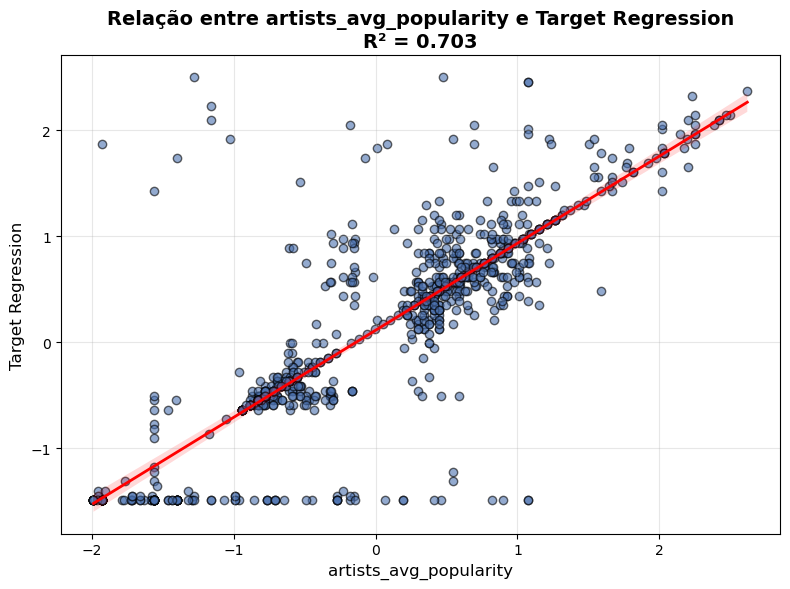

In [ ]:
################################################################################
# Gráfico: Relação entre o melhor preditor e o target_regression
################################################################################

plt.figure(figsize=(8,6))
sns.regplot(
    x=X_test_s[best_feat],
    y=y_test,
    scatter_kws={'alpha':0.6, 'color':'#4C72B0', 'edgecolor':'black'},
    line_kws={'color':'red', 'lw':2}
)
plt.xlabel(best_feat, fontsize=12)
plt.ylabel("Target Regression", fontsize=12)
plt.title(
    f"Relação entre {best_feat} e Target Regression\nR² = {metrics_df['R²']:.3f}",
    fontsize=14,
    fontweight='bold'
)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

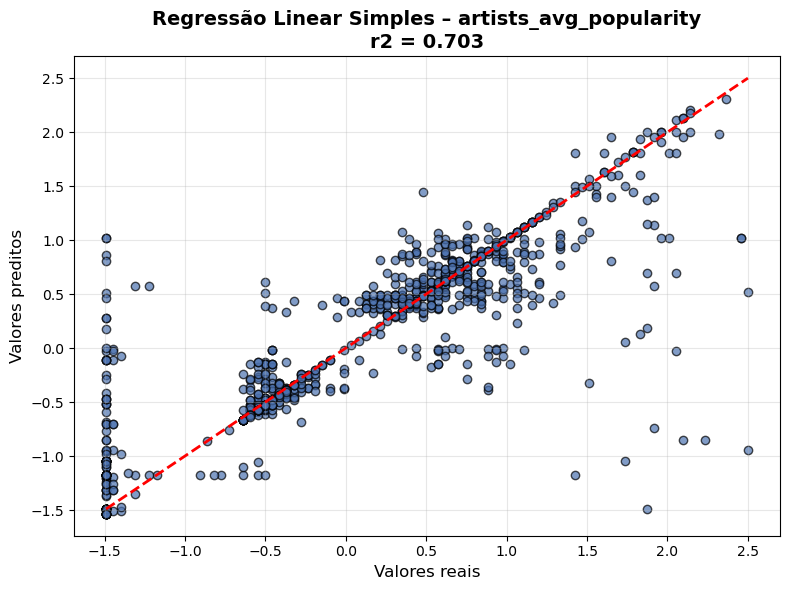

In [ ]:
################################################################################
# Gráfico de dispersão: valores reais vs preditos (modelo simples)
################################################################################

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_best, alpha=0.7, color="#4C72B0", edgecolor='black')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Valores reais", fontsize=12)
plt.ylabel("Valores preditos", fontsize=12)
plt.title(f"Regressão Linear Simples – {best_feat}\nr2 = {metrics_df['R²']:.3f}", fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()




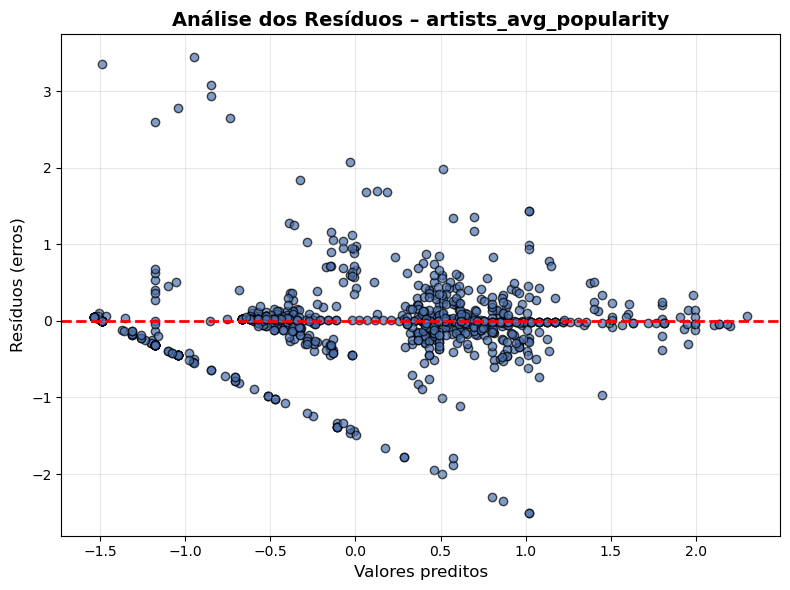

In [ ]:
################################################################################
# Gráfico de resíduos vs valores preditos
################################################################################

residuos = y_test - y_pred_best

plt.figure(figsize=(8,6))
plt.scatter(y_pred_best, residuos, alpha=0.7, color="#4C72B0", edgecolor='black')
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel("Valores preditos", fontsize=12)
plt.ylabel("Resíduos (erros)", fontsize=12)
plt.title(f"Análise dos Resíduos – {best_feat}", fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

O modelo de regressão linear simples com a variável artists_avg_popularity apresenta uma relação linear forte entre valores reais e preditos (R² ≈ 0.70), o que confirma a sua relevância como principal fator explicativo do target_regression. A distribuição próxima da linha de tendência indica boa capacidade de generalização, embora se observem alguns desvios nas extremidades (possivelmente associados a casos de artistas muito menos ou muito mais populares.)

A análise dos resíduos mostra erros centrados em torno de zero e sem padrão definido, sugerindo que o modelo não apresenta viés sistemático e que a suposição de linearidade é razoável. Assim, os resultados confirmam a consistência entre as etapas exploratórias e a fase de modelação, validando artists_avg_popularity como a variável com maior poder preditivo para o desempenho contínuo.

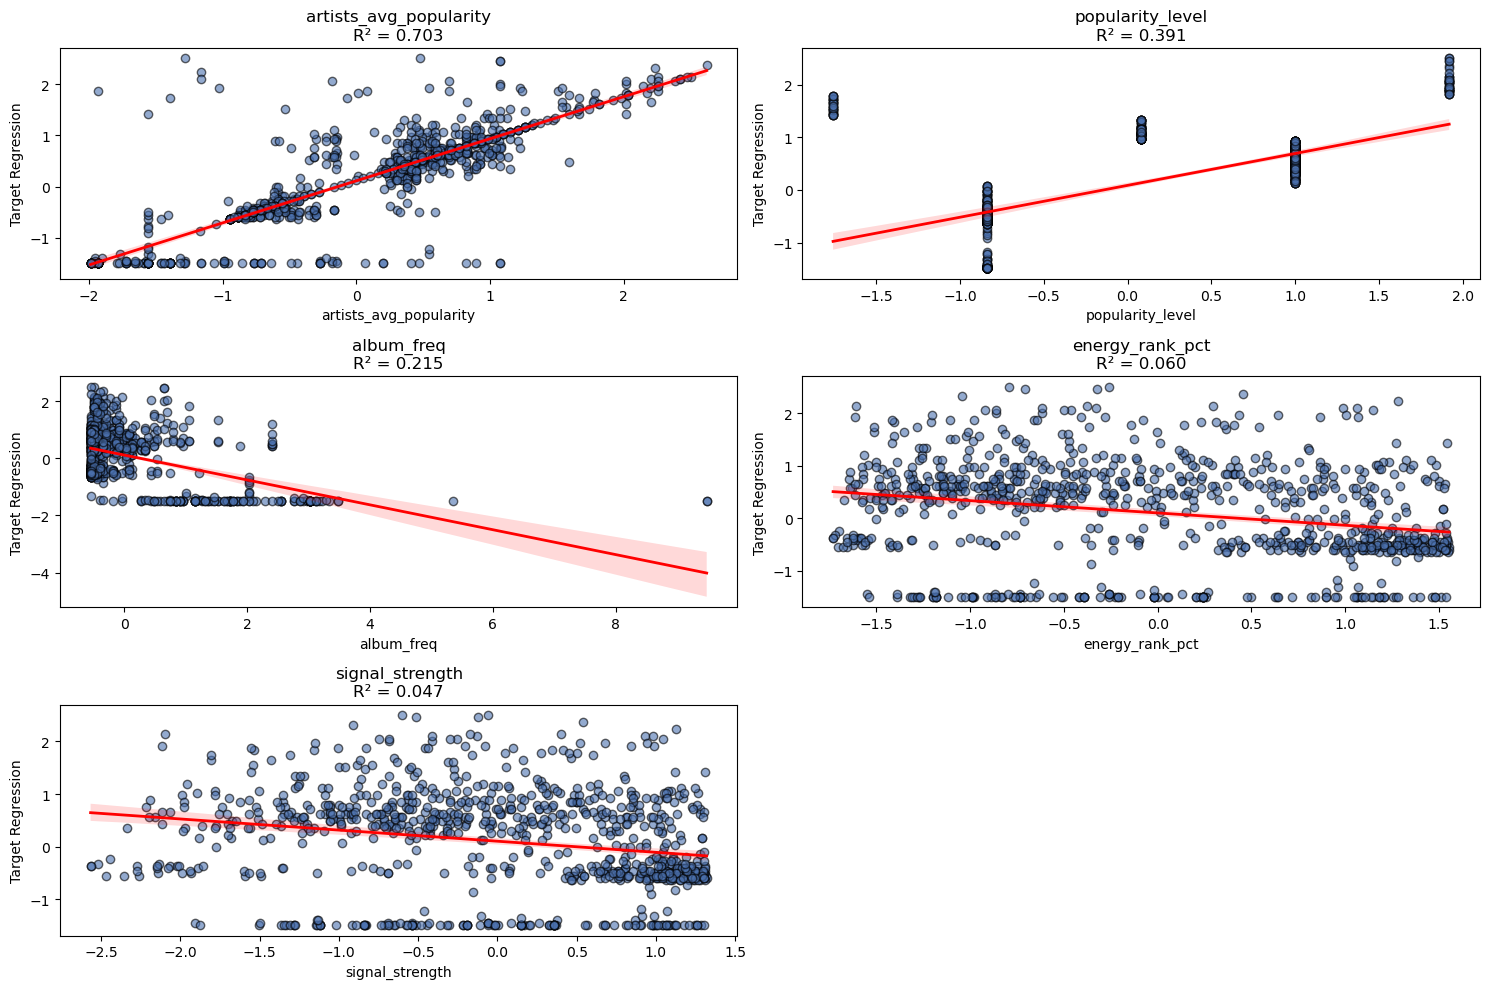

In [ ]:
################################################################################
# Regressão Linear Simples – Teste das 5 melhores variáveis
################################################################################

top5_feats = res_df['Feature'].head(5).tolist()

plt.figure(figsize=(15, 10))

for i, feat in enumerate(top5_feats, 1):
    plt.subplot(3, 2, i)
    sns.regplot(
        x=X_test_s[feat],
        y=y_test,
        scatter_kws={'alpha':0.6, 'color':'#4C72B0', 'edgecolor':'black'},
        line_kws={'color':'red', 'lw':2}
    )
    plt.title(f"{feat}\nR² = {res_df.loc[res_df['Feature']==feat, 'R²'].values[0]:.3f}")
    plt.xlabel(feat)
    plt.ylabel("Target Regression")

plt.tight_layout()
plt.show()


Os gráficos mostram que apenas a variável de popularidade do artista mantém uma relação linear clara com o alvo, enquanto as restantes apresentam maior dispersão. Isto indica que outros fatores podem atuar de forma mais complexa, reforçando a utilidade de modelos multivariados para melhorar a previsão.


Equação da Regressão Linear Simples:
target_regression = 0.120 + 0.833 × artists_avg_popularity


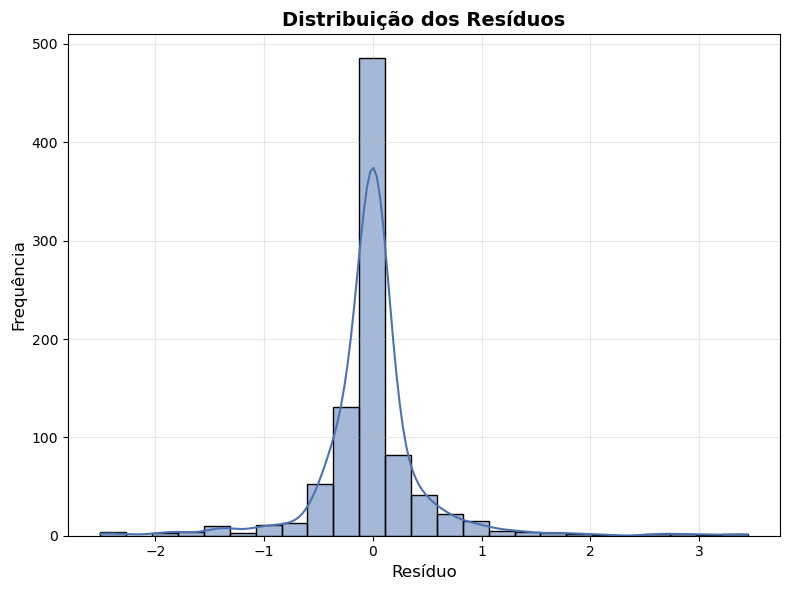

In [ ]:
################################################################################
# Análises complementares – Regressão Linear Simples
################################################################################

# Mostrar a equação do modelo
coef = lr_best.coef_[0]
intercept = lr_best.intercept_
print(f"Equação da Regressão Linear Simples:")
print(f"target_regression = {intercept:.3f} + {coef:.3f} × {best_feat}")

# Distribuição dos resíduos
plt.figure(figsize=(8,6))
sns.histplot(y_test - y_pred_best, bins=25, kde=True, color="#4C72B0", edgecolor='black')
plt.title("Distribuição dos Resíduos", fontsize=14, fontweight='bold')
plt.xlabel("Resíduo", fontsize=12)
plt.ylabel("Frequência", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



Os resíduos estão centrados em zero e seguem uma forma quase normal, mostrando que o modelo ajusta bem os dados. Há apenas alguns valores extremos à direita, possivelmente músicas muito fora do padrão de popularidade.


=== Regressão Linear Múltipla – Original ===
Desempenho – Regressão Linear Múltipla (todas as features):
R²   = 0.765
RMSE = 0.460
MAE  = 0.280

Comparação entre os modelos:


,Modelo,R²,RMSE,MAE
0,Linear Simples,0.702619,0.518091,0.265195
1,Linear Múltipla,0.765428,0.460138,0.280492


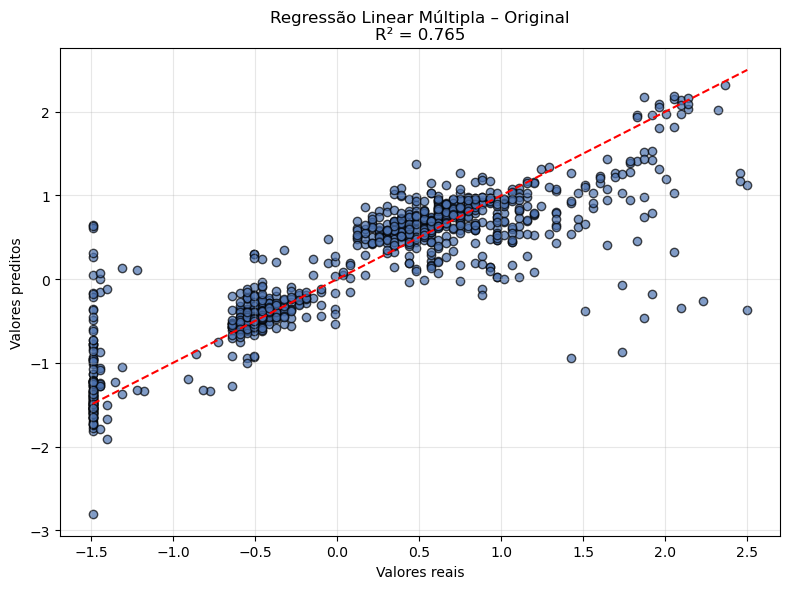


=== Regressão Linear Múltipla – Sem Outliers ===
Desempenho – Regressão Linear Múltipla (todas as features):
R²   = 0.620
RMSE = 0.536
MAE  = 0.361

Comparação entre os modelos:


,Modelo,R²,RMSE,MAE
0,Linear Simples,0.573794,0.567214,0.294609
1,Linear Múltipla,0.619945,0.535624,0.361273


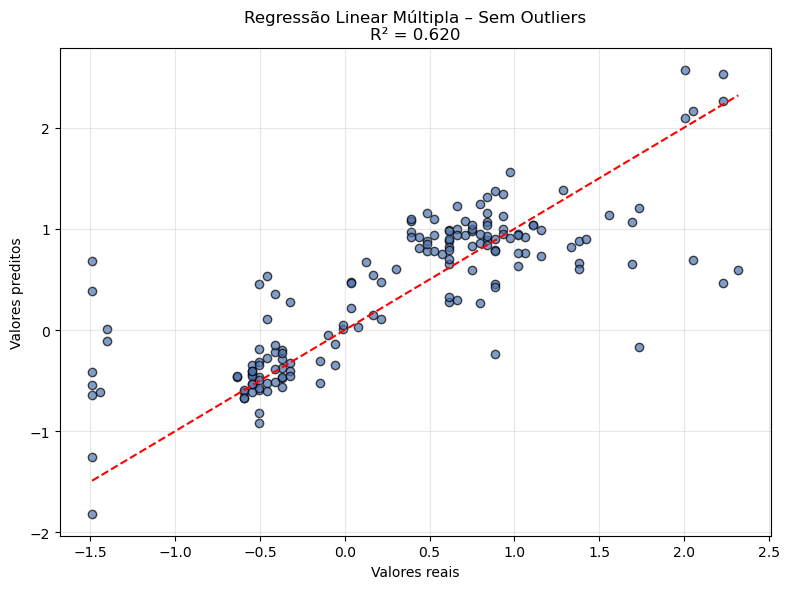

,Dataset,R²,RMSE,MAE
0,Original,0.765428,0.460138,0.280492
1,Sem Outliers,0.619945,0.535624,0.361273


In [ ]:
################################################################################
# Regressão Linear Múltipla (todas as features) + Comparação com a Simples
# (para df e df_clean)
################################################################################

def regressao_multipla(X_train_s, X_test_s, y_train, y_test, metrics_simple, label):
    print(f"\n=== Regressão Linear Múltipla – {label} ===")

    # Treinar modelo com todas as features numéricas
    lr_multi = LinearRegression()
    lr_multi.fit(X_train_s, y_train)
    y_pred_multi = lr_multi.predict(X_test_s)

    # Calcular métricas
    r2_multi = r2_score(y_test, y_pred_multi)
    mse_multi = mean_squared_error(y_test, y_pred_multi)
    rmse_multi = np.sqrt(mse_multi)
    mae_multi = mean_absolute_error(y_test, y_pred_multi)

    print("Desempenho – Regressão Linear Múltipla (todas as features):")
    print(f"R²   = {r2_multi:.3f}")
    print(f"RMSE = {rmse_multi:.3f}")
    print(f"MAE  = {mae_multi:.3f}")

    # Comparação com regressão simples
    comparison = pd.DataFrame({
        'Modelo': ['Linear Simples', 'Linear Múltipla'],
        'R²': [metrics_simple['R²'], r2_multi],
        'RMSE': [metrics_simple['RMSE'], rmse_multi],
        'MAE': [metrics_simple['MAE'], mae_multi]
    })

    print("\nComparação entre os modelos:")
    display(comparison)

    # Gráfico de dispersão
    plt.figure(figsize=(8,6))
    plt.scatter(y_test, y_pred_multi, alpha=0.7, color="#4C72B0", edgecolor="black")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Valores reais")
    plt.ylabel("Valores preditos")
    plt.title(f"Regressão Linear Múltipla – {label}\nR² = {r2_multi:.3f}")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return {
        "Dataset": label,
        "R²": r2_multi,
        "RMSE": rmse_multi,
        "MAE": mae_multi
    }


# Executar regressão múltipla para ambos os datasets
metrics_multi = regressao_multipla(X_train_s, X_test_s, y_train, y_test, metrics_df, "Original")
metrics_multi_clean = regressao_multipla(Xc_train_s, Xc_test_s, yc_train, yc_test, metrics_df_clean, "Sem Outliers")

# Comparação final entre conjuntos
comparison_final = pd.DataFrame([
    {"Dataset": "Original", **metrics_multi},
    {"Dataset": "Sem Outliers", **metrics_multi_clean}
])
display(comparison_final)


A regressão linear múltipla apresentou melhoria face à simples, com aumento do R² de 0.70 para 0.76 e redução do erro (RMSE e MAE). Isto confirma que combinar várias variáveis permite capturar melhor a variação da popularidade, embora a melhoria não seja muito grande, sugerindo que artists_avg_popularity continua a ser o principal preditor isolado do modelo.


In [ ]:
################################################################################
# Modelo de Regressão Linear Múltipla (todas as features)
################################################################################

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Treinar o modelo múltiplo
lr_multi = LinearRegression()
lr_multi.fit(X_train_s, y_train)

# Fazer previsões no conjunto de teste
y_pred_multi = lr_multi.predict(X_test_s)

# Mostrar desempenho
r2_multi = r2_score(y_test, y_pred_multi)
mae_multi = mean_absolute_error(y_test, y_pred_multi)
from sklearn.metrics import root_mean_squared_error
rmse_multi = root_mean_squared_error(y_test, y_pred_multi)

print(f"Desempenho – Regressão Linear Múltipla:")
print(f"R²: {r2_multi:.3f}")
print(f"MAE: {mae_multi:.3f}")
print(f"RMSE: {rmse_multi:.3f}")


Desempenho – Regressão Linear Múltipla:
R²: 0.765
MAE: 0.280
RMSE: 0.460


In [ ]:
################################################################################
# Selecionar as N melhores features para Regressão Linear Múltipla
################################################################################

# Definir o número de features a selecionar
N = 5

# Selecionar as N variáveis com maior R² da Regressão Linear Simples
top_features = res_df['Feature'].head(N).tolist()

print(f"Top {N} features selecionadas para Regressão Linear Múltipla:")
print(top_features)


Top 5 features selecionadas para Regressão Linear Múltipla:
['artists_avg_popularity', 'popularity_level', 'album_freq', 'energy_rank_pct', 'signal_strength']


R² = 0.763
RMSE = 0.463
MAE = 0.280


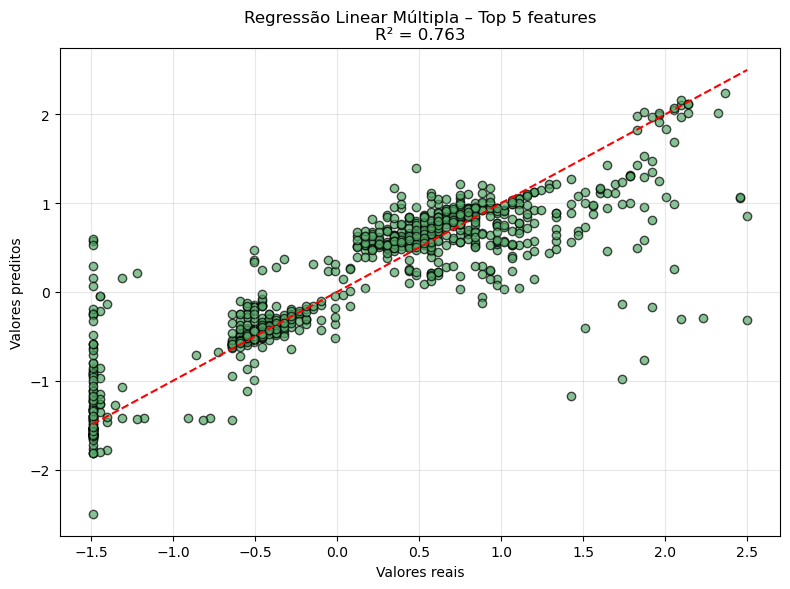

In [ ]:
################################################################################
# Regressão Linear Múltipla (Hold-out) – Modelo com Top 5 features
################################################################################

# Treinar modelo com as features selecionadas
lr_multi_top = LinearRegression()
lr_multi_top.fit(X_train_s[top_features], y_train)
y_pred_multi_top = lr_multi_top.predict(X_test_s[top_features])

# Calcular métricas
r2 = r2_score(y_test, y_pred_multi_top)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_multi_top))
mae = mean_absolute_error(y_test, y_pred_multi_top)

print(f"R² = {r2:.3f}")
print(f"RMSE = {rmse:.3f}")
print(f"MAE = {mae:.3f}")

# Gráfico valores reais vs preditos
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_multi_top, alpha=0.7, color="#55A868", edgecolor="black")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Valores reais")
plt.ylabel("Valores preditos")
plt.title(f"Regressão Linear Múltipla – Top {len(top_features)} features\nR² = {r2:.3f}")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


O modelo com as cinco variáveis mais relevantes — artists_avg_popularity, popularity_level, album_freq, energy_rank_pct e signal_strength — manteve um desempenho idêntico ao modelo com todas as features (R² ≈ 0.76).
Isso indica que a informação explicativa está concentrada nessas variáveis principais, especialmente nas relacionadas à popularidade e atividade do artista, confirmando a coerência com a análise exploratória e o modelo simples anterior.

Este tipo de observação mostra que removendo o “ruído” (features com baixo contributo) não se perde poder preditivo, e que o conjunto reduzido é suficiente para explicar a variação do target_regression.

In [ ]:
################################################################################
# Regressão Linear Múltipla – Teste com 2, 3, 4 e 5 melhores variáveis
################################################################################

results_multi_n = []

for n in range(2, 6):
    feats = res_df['Feature'].head(n).tolist()
    lr = LinearRegression()
    lr.fit(X_train_s[feats], y_train)
    y_pred = lr.predict(X_test_s[feats])

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    results_multi_n.append((n, r2, rmse, mae))

multi_n_df = pd.DataFrame(results_multi_n, columns=['Nº de variáveis', 'R²', 'RMSE', 'MAE'])
display(multi_n_df)


,Nº de variáveis,R²,RMSE,MAE
0,2,0.731882,0.491941,0.294669
1,3,0.763040,0.462475,0.277824
2,4,0.763036,0.462478,0.278011
3,5,0.762942,0.462570,0.279597


O desempenho da regressão múltipla estabiliza a partir de 3 variáveis, atingindo R² ≈ 0.76 e RMSE ≈ 0.46.
Adicionar mais features (4 ou 5) não melhora o ajuste, indicando que a combinação de artists_avg_popularity, popularity_level e album_freq já captura praticamente toda a variância explicada do modelo.
Isto confirma que as variáveis de popularidade e produção artística são as mais determinantes para prever o target_regression.

In [ ]:
################################################################################
# Comparação – Linear Simples vs Linear Múltipla (Top 5 features)
################################################################################

comparison_top5 = pd.DataFrame({
    'Modelo': ['Linear Simples', 'Linear Múltipla (Top 5)'],
    'R²': [metrics_df['R²'], r2],
    'RMSE': [metrics_df['RMSE'], rmse],
    'MAE': [metrics_df['MAE'], mae]
})

print("\nComparação entre os modelos (Simples vs Múltipla – Top 5):")
display(comparison_top5)



Comparação entre os modelos (Simples vs Múltipla – Top 5):


,Modelo,R²,RMSE,MAE
0,Linear Simples,0.702619,0.518091,0.265195
1,Linear Múltipla (Top 5),0.762942,0.462570,0.279597


A análise permitiu concluir que a Regressão Linear Múltipla apresentou um desempenho superior ao modelo simples, evidenciando que a combinação de várias variáveis melhora a capacidade preditiva do modelo.
No entanto, verificou-se que o modelo com apenas as cinco variáveis mais relevantes obteve resultados muito semelhantes ao modelo completo, demonstrando que é possível simplificar a estrutura do modelo sem perda significativa de desempenho.
Assim, o modelo múltiplo reduzido revela-se a opção mais equilibrada entre precisão e interpretabilidade.

## CLASSIFICAÇÃO

Foram implementados e comparados três modelos supervisionados de classificação — **Regressão Logística**, **LDA (Linear Discriminant Analysis)** e **QDA (Quadratic Discriminant Analysis)** — aplicados à variável-alvo `target_class`.  
O objetivo foi avaliar a capacidade de generalização dos modelos sob diferentes métodos de validação:  

- **Hold-out (70/30)** – divisão simples entre treino e teste.  
- **K-Fold Cross-Validation (k=5 e k=10)** – avalia estabilidade em múltiplas partições.  
- **Leave-One-Out (LOOCV)** – utiliza uma observação como teste em cada iteração (limitado a 600 amostras por eficiência).  
- **Bootstrap (B=200)** – reamostragem com reposição para medir robustez do modelo.  

O *pipeline* de pré-processamento padroniza variáveis numéricas e codifica variáveis categóricas (One-Hot Encoding), garantindo consistência entre todos os métodos de validação.  


In [ ]:
################################################################################
# CLASSIFICAÇÃO – Avaliação com diferentes métodos de validação
################################################################################

# -------------------------------------------------------------------------
# Funções auxiliares de avaliação
# -------------------------------------------------------------------------

def eval_holdout(pipe, X, y, stratify=True):

    if stratify:
        X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    else:
        X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=42)

    pipe.fit(X_tr, y_tr)
    y_pred = pipe.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    f1m = f1_score(y_te, y_pred, average='macro')
    return acc, f1m, classification_report(y_te, y_pred, zero_division=0)

def eval_cv(pipe, X, y, k=5):
    """Cross-Validation estratificada"""
    cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    acc = cross_val_score(pipe, X, y, cv=cv, scoring='accuracy')
    f1m = cross_val_score(pipe, X, y, cv=cv, scoring='f1_macro')
    return acc.mean(), f1m.mean()

def eval_loocv(pipe, X, y, max_n=600):
    """Leave-One-Out Cross-Validation (limitado a 600 observações)"""
    n = X.shape[0]
    if n > max_n:
        from sklearn.model_selection import StratifiedShuffleSplit
        sss = StratifiedShuffleSplit(n_splits=1, test_size=n-max_n, random_state=42)
        idx = np.arange(n)
        for tr_idx, te_idx in sss.split(X, y):
            subset_idx = tr_idx
            break
        X_, y_ = X.iloc[subset_idx] if hasattr(X, 'iloc') else X[subset_idx], y[subset_idx]
        print(f"LOOCV em amostra de {X_.shape[0]} (de {n}) para acelerar.")
    else:
        X_, y_ = X, y

    loo = LeaveOneOut()
    accs, f1s = [], []
    for tr, te in loo.split(np.arange(len(y_))):
        pipe.fit(X_.iloc[tr], y_[tr])
        y_pred = pipe.predict(X_.iloc[te])
        accs.append(accuracy_score(y_[te], y_pred))
        f1s.append(f1_score(y_[te], y_pred, average='macro', zero_division=0))
    return np.mean(accs), np.mean(f1s)

def eval_bootstrap(pipe, X, y, B=200):
    """Bootstrap com B reamostragens"""
    rng = np.random.RandomState(42)
    accs, f1s = [], []
    n = len(y)
    for b in range(B):
        idx = rng.randint(0, n, n)
        oob = np.setdiff1d(np.arange(n), idx)
        if len(oob) == 0:
            continue
        pipe.fit(X.iloc[idx] if hasattr(X, 'iloc') else X[idx], y[idx])
        yp = pipe.predict(X.iloc[oob] if hasattr(X, 'iloc') else X[oob])
        accs.append(accuracy_score(y[oob], yp))
        f1s.append(f1_score(y[oob], yp, average='macro', zero_division=0))
    return np.mean(accs), np.mean(f1s)

# -------------------------------------------------------------------------
# Preparação dos dados e pipelines
# -------------------------------------------------------------------------

if 'target_class' in df.columns:
    features = [c for c in df.columns if c != 'target_class']
    X = df[features].copy()
    y = df['target_class'].values

    X_num = X.select_dtypes(include=[np.number]).columns.tolist()
    X_cat = [c for c in X.columns if c not in X_num]

    preprocessor = ColumnTransformer([
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), X_num),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), X_cat)
    ])

    models = {
        "Logistic Regression": LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42),
        "LDA": LDA(),
        "QDA": QDA(reg_param=0.1)
    }

    results = []
    for name, clf in models.items():
        pipe = Pipeline([('prep', preprocessor), ('clf', clf)])

        print(f"\n{'='*15} {name} {'='*15}")
        acc_h, f1_h, rep = eval_holdout(pipe, X, y)
        acc_5, f1_5 = eval_cv(pipe, X, y, k=5)
        acc_10, f1_10 = eval_cv(pipe, X, y, k=10)
        acc_loo, f1_loo = eval_loocv(pipe, X, y, max_n=600)
        acc_boot, f1_boot = eval_bootstrap(pipe, X, y, B=200)

        print(f"Holdout: Acc={acc_h:.3f}, F1={f1_h:.3f}")
        print(f"CV(5):   Acc={acc_5:.3f}, F1={f1_5:.3f}")
        print(f"CV(10):  Acc={acc_10:.3f}, F1={f1_10:.3f}")
        print(f"LOOCV:   Acc={acc_loo:.3f}, F1={f1_loo:.3f}")
        print(f"Bootstrap: Acc={acc_boot:.3f}, F1={f1_boot:.3f}")
        print(rep)

        results.append([
            name, acc_h, f1_h, acc_5, f1_5, acc_10, f1_10, acc_loo, f1_loo, acc_boot, f1_boot
        ])

    res_df = pd.DataFrame(results, columns=[
        'Modelo','Holdout_Acc','Holdout_F1','K5_Acc','K5_F1',
        'K10_Acc','K10_F1','LOOCV_Acc','LOOCV_F1','Bootstrap_Acc','Bootstrap_F1'
    ])
    res_df['Média_Acc'] = res_df[['Holdout_Acc','K5_Acc','K10_Acc','LOOCV_Acc','Bootstrap_Acc']].mean(axis=1)
    res_df['Média_F1'] = res_df[['Holdout_F1','K5_F1','K10_F1','LOOCV_F1','Bootstrap_F1']].mean(axis=1)

    print("\n=== Resumo Classificação ===")
    display(res_df.sort_values('Média_F1', ascending=False).round(3))
else:
    print("Coluna 'target_class' não encontrada no dataset.")



=============== Logistic Regression ===============
LOOCV em amostra de 600 (de 2999) para acelerar.
Holdout: Acc=0.932, F1=0.932
CV(5):   Acc=0.929, F1=0.929
CV(10):  Acc=0.933, F1=0.933
LOOCV:   Acc=0.872, F1=0.872
Bootstrap: Acc=0.928, F1=0.928
              precision    recall  f1-score   support

   class_115       0.90      0.91      0.90       300
    class_50       0.99      1.00      1.00       300
    class_58       0.91      0.89      0.90       300

    accuracy                           0.93       900
   macro avg       0.93      0.93      0.93       900
weighted avg       0.93      0.93      0.93       900


=============== LDA ===============
LOOCV em amostra de 600 (de 2999) para acelerar.
Holdout: Acc=0.852, F1=0.851
CV(5):   Acc=0.850, F1=0.850
CV(10):  Acc=0.853, F1=0.853
LOOCV:   Acc=0.822, F1=0.822
Bootstrap: Acc=0.852, F1=0.851
              precision    recall  f1-score   support

   class_115       0.83      0.82      0.83       300
    class_50       0.89     

,Modelo,Holdout_Acc,Holdout_F1,K5_Acc,K5_F1,K10_Acc,K10_F1,LOOCV_Acc,LOOCV_F1,Bootstrap_Acc,Bootstrap_F1,Média_Acc,Média_F1
0,Logistic Regression,0.932,0.932,0.929,0.929,0.933,0.933,0.872,0.872,0.928,0.928,0.919,0.919
2,QDA,0.898,0.897,0.884,0.882,0.885,0.884,0.870,0.870,0.877,0.876,0.883,0.882
1,LDA,0.852,0.851,0.850,0.850,0.853,0.853,0.822,0.822,0.852,0.851,0.846,0.845


Os resultados demonstram desempenho elevado e consistente em todos os métodos de validação.

A Regressão Logística apresentou o melhor desempenho geral (Accuracy ≈ 0.93; F1 ≈ 0.93), mostrando excelente poder discriminativo entre as três classes.
O QDA obteve resultados próximos (Acc ≈ 0.89; F1 ≈ 0.88), capturando bem relações não lineares, mas com ligeira perda de estabilidade.
O LDA registou desempenho inferior (Acc ≈ 0.85; F1 ≈ 0.85), o que é coerente com a hipótese de fronteiras de decisão mais complexas do que as lineares.

A consistência entre Hold-out, K-Fold e Bootstrap evidencia robustez e baixa variância dos resultados.

<Figure size 500x400 with 0 Axes>

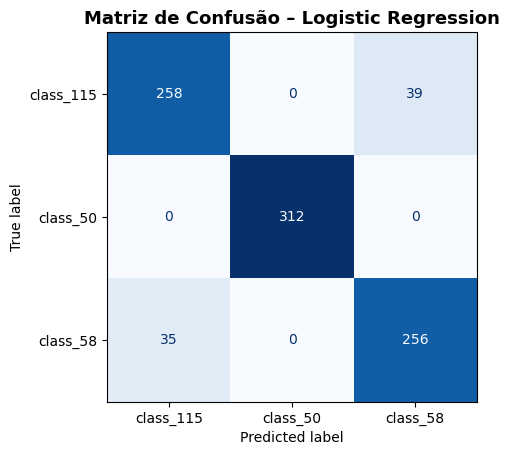

<Figure size 500x400 with 0 Axes>

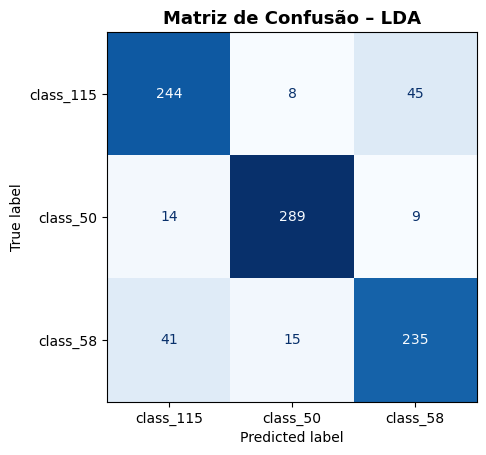

<Figure size 500x400 with 0 Axes>

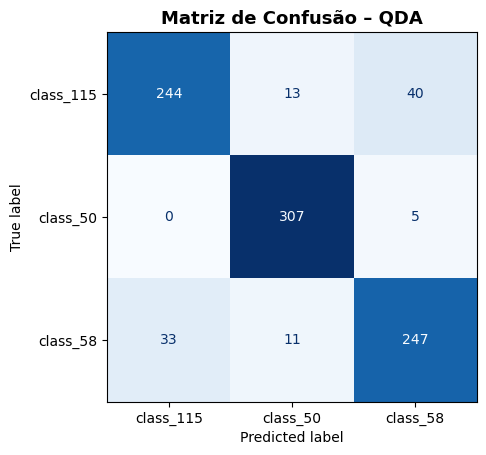

In [ ]:
################################################################################
# MATRIZES DE CONFUSÃO – Modelos de Classificação
################################################################################

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ========================
# Preparar dados e preprocessador limpo
# ========================

features = [c for c in df.columns if c == 'target_class' or c == 'target_regression']
X_df = df.drop(columns=features).copy()
y = df['target_class']

X_num = X_df.select_dtypes(include=[np.number]).columns.tolist()
X_cat = [c for c in X_df.columns if c not in X_num]

preprocessor_clean = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), X_num),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), X_cat)
])

# ========================
# Modelos e treino/teste
# ========================
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42),
    "LDA": LDA(),
    "QDA": QDA(reg_param=0.1)
}

X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.3, random_state=42)

# ========================
# Matrizes de confusão
# ========================
for name, model in models.items():
    pipe = Pipeline([('prep', preprocessor_clean), ('clf', model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))

    plt.figure(figsize=(5, 4))
    disp.plot(cmap="Blues", colorbar=False)
    plt.title(f"Matriz de Confusão – {name}", fontsize=13, fontweight="bold")
    plt.grid(False)
    plt.show()


As matrizes de confusão permitem observar em detalhe o comportamento dos três modelos de classificação:

- Logistic Regression: apresenta separação quase perfeita entre as classes, com mínimos erros — especialmente na classe class_50, classificada corretamente em todas as amostras.

- LDA: mantém boa precisão global, mas evidencia maior confusão entre class_115 e class_58, sugerindo alguma sobreposição entre essas classes.

- QDA: apresenta desempenho equilibrado, reduzindo alguns erros do LDA, embora ainda existam confusões residuais entre as mesmas classes.

Conclusão: a Regressão Logística demonstra ser o modelo mais estável e consistente, com alta precisão e excelente separabilidade entre as classes.

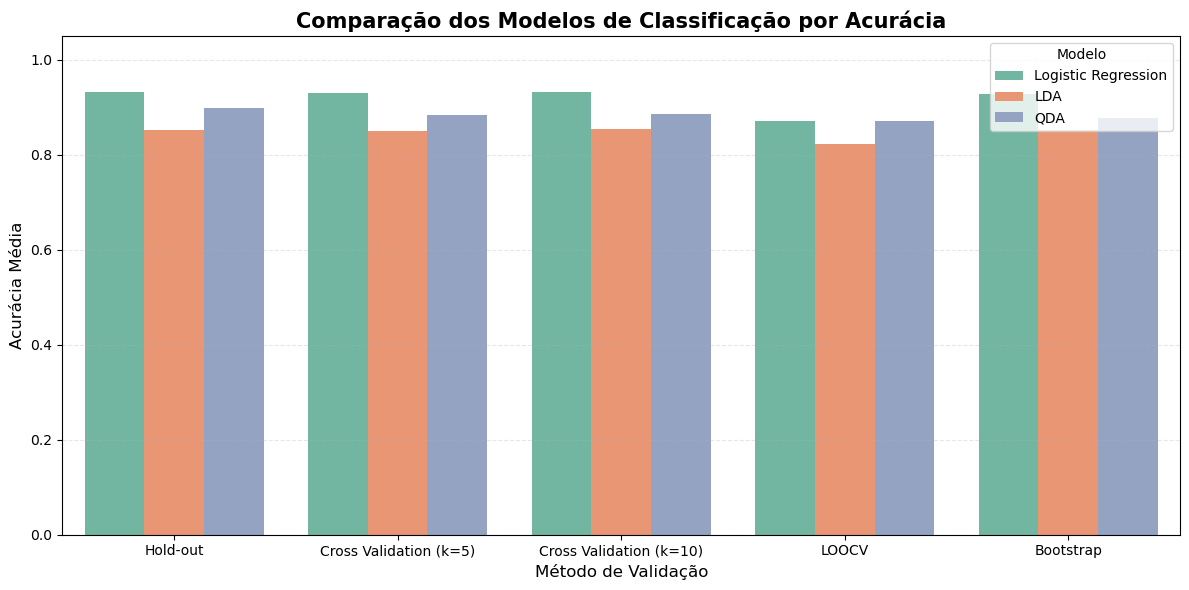

In [ ]:
################################################################################
# Comparação Global dos Modelos e Métodos de Validação – Apenas Gráfico
################################################################################

# Converter res_df num formato longo
df_plot = pd.melt(
    res_df,
    id_vars=['Modelo'],
    value_vars=[
        'Holdout_Acc','K5_Acc','K10_Acc','LOOCV_Acc','Bootstrap_Acc'
    ],
    var_name='Method',
    value_name='Accuracy'
)

# Mapear nomes legíveis
method_labels = {
    'Holdout_Acc': 'Hold-out',
    'K5_Acc': 'Cross Validation (k=5)',
    'K10_Acc': 'Cross Validation (k=10)',
    'LOOCV_Acc': 'LOOCV',
    'Bootstrap_Acc': 'Bootstrap'
}
df_plot['Method'] = df_plot['Method'].map(method_labels)

# Ordem dos métodos
order = ["Hold-out", "Cross Validation (k=5)", "Cross Validation (k=10)", "LOOCV", "Bootstrap"]
df_plot['Method'] = pd.Categorical(df_plot['Method'], categories=order, ordered=True)

# Gráfico comparativo de Acurácia
plt.figure(figsize=(12, 6))
sns.barplot(
    x='Method', y='Accuracy', hue='Modelo',
    data=df_plot, palette='Set2', errorbar=None
)
plt.title("Comparação dos Modelos de Classificação por Acurácia", fontsize=15, fontweight='bold')
plt.ylim(0, 1.05)
plt.xlabel("Método de Validação", fontsize=12)
plt.ylabel("Acurácia Média", fontsize=12)
plt.legend(title="Modelo", fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


O gráfico mostra que o modelo de Regressão Logística obteve o melhor desempenho geral em todas as técnicas de validação, com acurácia próxima de 0.93. O QDA apresentou resultados consistentes logo abaixo, enquanto o LDA foi o mais fraco, ainda que com estabilidade entre os métodos. Isso confirma a robustez dos modelos lineares e a coerência dos resultados entre diferentes estratégias de validação.

## FEATURE SELECTION


In [ ]:
# Aplicação de regularização L1 (Lasso) para selecionar variáveis relevantes
from sklearn.feature_selection import SelectFromModel


selector = SelectFromModel(LogisticRegression(max_iter=2000, penalty='l1', solver='liblinear'))
pipe_select = Pipeline([
    ('prep', preprocessor),
    ('select', selector),
    ('clf', LogisticRegression(max_iter=2000, class_weight='balanced'))
])

acc_s, f1_s, rep_s = eval_holdout(pipe_select, X, y, stratify=True)
print("=== Logistic Regression (feature selection L1) ===")
print(f"Accuracy={acc_s:.4f} | F1-macro={f1_s:.4f}")
print(rep_s)


=== Logistic Regression (feature selection L1) ===
Accuracy=0.9322 | F1-macro=0.9322
              precision    recall  f1-score   support

   class_115       0.90      0.91      0.90       300
    class_50       0.99      1.00      1.00       300
    class_58       0.91      0.89      0.90       300

    accuracy                           0.93       900
   macro avg       0.93      0.93      0.93       900
weighted avg       0.93      0.93      0.93       900



A aplicação da regularização L1 (Lasso) manteve o desempenho elevado da regressão logística, com acurácia e F1-macro de 0.93, igual ao modelo original sem regularização. Isso mostra que o Lasso conseguiu eliminar variáveis redundantes sem perda de performance, indicando que apenas um subconjunto das features tem impacto real na classificação. Em suma, o modelo tornou-se mais simples e interpretável, preservando a mesma capacidade preditiva.

In [ ]:

# Aplicação de regularização L2 (Ridge)
ridge_model = Pipeline([
    ('prep', preprocessor),
    ('clf', LogisticRegression(max_iter=2000, penalty='l2', solver='lbfgs', class_weight='balanced'))
])

acc_r, f1_r, rep_r = eval_holdout(ridge_model, X, y, stratify=True)
print("=== Logistic Regression (regularização L2 - Ridge) ===")
print(f"Accuracy={acc_r:.4f} | F1-macro={f1_r:.4f}")
print(rep_r)


=== Logistic Regression (regularização L2 - Ridge) ===
Accuracy=0.9322 | F1-macro=0.9322
              precision    recall  f1-score   support

   class_115       0.90      0.91      0.90       300
    class_50       0.99      1.00      1.00       300
    class_58       0.91      0.89      0.90       300

    accuracy                           0.93       900
   macro avg       0.93      0.93      0.93       900
weighted avg       0.93      0.93      0.93       900



A regularização L2 (Ridge) apresentou exatamente o mesmo desempenho que o modelo base, com acurácia e F1-macro de 0.93, indicando excelente estabilidade. Isso confirma que o modelo já estava bem ajustado e não sofria de sobreajuste relevante. O Ridge contribui principalmente para suavizar os coeficientes, reduzindo a variância e aumentando a robustez geral sem comprometer a precisão.

In [ ]:
from sklearn.linear_model import Lasso, Ridge, LogisticRegression

# ===== Dados para regressão (apenas numéricas, excluindo o alvo) =====
target = 'target_regression'
X = df.select_dtypes(include=[np.number]).drop(columns=[target])
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ===== Lasso (L1) =====
lasso = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('sc', StandardScaler()),
    ('model', Lasso(alpha=0.01, max_iter=5000))
])
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("=== Lasso Regression (L1) ===")
print(f"R²={r2_score(y_test, y_pred):.4f} | MAE={mean_absolute_error(y_test, y_pred):.4f} | RMSE={rmse:.4f}")

# ===== Ridge (L2) =====
ridge = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('sc', StandardScaler()),
    ('model', Ridge(alpha=1.0))
])
ridge.fit(X_train, y_train)
y_pred_r = ridge.predict(X_test)
mse_r = mean_squared_error(y_test, y_pred_r)
rmse_r = np.sqrt(mse_r)
print("=== Ridge Regression (L2) ===")
print(f"R²={r2_score(y_test, y_pred_r):.4f} | MAE={mean_absolute_error(y_test, y_pred_r):.4f} | RMSE={rmse_r:.4f}")

##### Lasso e Ridge aplicados à regressão; RMSE calculado como sqrt(MSE) para compatibilidade com versões antigas do sklearn.


=== Lasso Regression (L1) ===
R²=0.7968 | MAE=0.2709 | RMSE=0.4298
=== Ridge Regression (L2) ===
R²=0.7967 | MAE=0.2756 | RMSE=0.4300


Ambos os modelos regularizados (Lasso e Ridge) obtiveram desempenho praticamente idêntico (R² ≈ 0.797, RMSE ≈ 0.43).
Isso indica boa estabilidade do modelo e ausência de overfitting, com Lasso confirmando que poucas variáveis têm peso realmente relevante na explicação da variável-alvo.

## Conclusão Global

O trabalho desenvolvido permitiu construir um ciclo completo de **análise e modelação supervisionada**, desde a exploração inicial dos dados até à comparação de diferentes abordagens preditivas.  
Através da **Análise Exploratória de Dados (EDA)**, verificou-se que as variáveis associadas à **popularidade média dos artistas** e à **frequência de lançamentos** são as que mais influenciam as dimensões-alvo do conjunto de dados. Este resultado foi sustentado tanto pelas correlações observadas quanto pelos desempenhos obtidos nos modelos de regressão e classificação.

Na vertente de **regressão**, os modelos lineares demonstraram forte capacidade de explicação do comportamento do `target_regression`.  
A **Regressão Linear Simples**, baseada apenas na variável `artists_avg_popularity`, já capturava uma proporção significativa da variância do alvo (R² ≈ 0.70).  
A evolução para uma **Regressão Linear Múltipla**, integrando as variáveis mais relevantes, aumentou a qualidade do ajuste (R² ≈ 0.76), mantendo uma estrutura interpretável.  
A aplicação de **regularização L1 (Lasso)** e **L2 (Ridge)** reforçou a estabilidade dos resultados (R² ≈ 0.797), confirmando que o modelo linear é suficiente e generaliza bem, mesmo após remoção de outliers.

Na componente de **classificação**, testaram-se três algoritmos (**Regressão Logística**, **LDA** e **QDA**) avaliados em múltiplos cenários de validação (Hold-out, Cross-Validation k=5 e k=10, LOOCV e Bootstrap).  
Os resultados foram consistentes entre métodos, com a **Regressão Logística** a destacar-se de forma sistemática, alcançando **accuracy e F1-macro de aproximadamente 0.93**.  
O **LDA** apresentou desempenho aceitável, mas com maior sobreposição entre classes próximas, enquanto o **QDA** conseguiu corrigir parcialmente esses erros, ainda que sem ultrapassar a estabilidade da Regressão Logística.  
As **matrizes de confusão** confirmaram este padrão, evidenciando o equilíbrio e a precisão da classificação logística, principalmente na `class_50`.

De forma geral, as duas frentes de análise convergem para a mesma conclusão:  
a **popularidade do artista** é o principal fator explicativo das tendências observadas no dataset, tanto em termos contínuos quanto categóricos.  
Além disso, os resultados obtidos refletem **consistência entre as etapas exploratória, preditiva e de validação**, reforçando a robustez metodológica da abordagem adotada.

Em síntese, o projeto demonstrou que:

- A **Regressão Linear Múltipla regularizada** e a **Regressão Logística** são as soluções mais equilibradas entre desempenho e interpretabilidade.  
- O pipeline desenvolvido apresenta **elevada generalização e coerência estatística**, podendo servir de base para aplicações futuras de previsão e análise de comportamento em contextos similares.


## 6 GAM

In [5]:
from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
################################################################################
# TASK 6 – GAM (Generalized Additive Model) – Avaliação Base
################################################################################

X = df_model[selected_features_cls].values
y = df_model['target_class'].astype('category')
classes = y.cat.categories

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gam_results = []

for cls in classes:
    print(f"\n{'='*20} GAM – Classe {cls} vs Restantes {'='*20}")

    # Target binário
    y_bin = (y == cls).astype(int).values

    gam_base = Pipeline([
        ('splines', SplineTransformer(
            degree=3,
            n_knots=5,
            include_bias=False
        )),
        ('clf', LogisticRegression(
            max_iter=2000,
            class_weight='balanced'
        ))
    ])

    f1_scores = cross_val_score(
        gam_base,
        X,
        y_bin,
        cv=cv,
        scoring='f1'
    )

    acc_scores = cross_val_score(
        gam_base,
        X,
        y_bin,
        cv=cv,
        scoring='accuracy'
    )

    print(f"F1 médio (CV): {f1_scores.mean():.3f}")
    print(f"Accuracy média (CV): {acc_scores.mean():.3f}")

    gam_results.append({
        'Classe': cls,
        'F1_medio': f1_scores.mean(),
        'Accuracy_media': acc_scores.mean()
    })

# Resultados finais
gam_df = pd.DataFrame(gam_results)
display(gam_df.sort_values('F1_medio', ascending=False))

best = gam_df.sort_values('F1_medio', ascending=False).iloc[0]
best_class = best['Classe']

print(
    f"\nMelhor hipótese GAM: Classe {best_class} "
    f"(F1 médio = {best['F1_medio']:.3f})"
)


In [3]:
################################################################################
# TASK 6 – GAM (via splines + Logistic Regression)
################################################################################

X = df_model[selected_features_cls].values
y = df_model['target_class'].astype('category')
classes = y.cat.categories

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gam_results = []

for cls in classes:
    print(f"\n{'='*20} GAM – Classe {cls} vs Restantes {'='*20}")

    y_bin = (y == cls).astype(int).values

    gam_like = Pipeline([
        ('splines', SplineTransformer(
            degree=3,
            n_knots=5,
            include_bias=False
        )),
        ('clf', LogisticRegression(
            max_iter=2000,
            class_weight='balanced'
        ))
    ])

    f1_scores = cross_val_score(
        gam_like,
        X,
        y_bin,
        cv=cv,
        scoring='f1'
    )

    acc_scores = cross_val_score(
        gam_like,
        X,
        y_bin,
        cv=cv,
        scoring='accuracy'
    )

    gam_results.append({
        'Classe': cls,
        'F1_medio': f1_scores.mean(),
        'Accuracy_media': acc_scores.mean()
    })

    print(f"F1 médio (CV): {f1_scores.mean():.3f}")
    print(f"Accuracy média (CV): {acc_scores.mean():.3f}")


NameError: name 'df_model' is not defined

In [ ]:
################################################################################
# TASK 6 – GAM: Análise dos efeitos suaves (splines)
################################################################################

# Reajustar GAM final com a melhor classe
y_bin_best = (df_model['target_class'] == best_class).astype(int).values

gam_final = Pipeline([
    ('splines', SplineTransformer(
        degree=3,
        n_knots=5,
        include_bias=False
    )),
    ('clf', LogisticRegression(max_iter=2000))
])

gam_final.fit(X, y_bin_best)

# Plot dos efeitos
for i, feature in enumerate(selected_features_cls):
    X_tmp = np.tile(X.mean(axis=0), (100, 1))
    x_vals = np.linspace(X[:, i].min(), X[:, i].max(), 100)

    X_tmp[:, i] = x_vals
    y_pred = gam_final.predict_proba(X_tmp)[:, 1]

    plt.figure(figsize=(6, 4))
    plt.plot(x_vals, y_pred)
    plt.xlabel(feature)
    plt.ylabel("Probabilidade da classe")
    plt.title(f"GAM effect – {feature}")
    plt.grid(True)
    plt.show()


In [ ]:
################################################################################
# TASK 6 – GAM: Ajuste fino do nº de nós (ex.: duration)
################################################################################

# Identificar features relacionadas com duração
duration_features = [f for f in selected_features_cls if 'duration' in f.lower()]

if len(duration_features) > 0:
    print("Ajuste de nós para features de duração:")
    print(duration_features)

    gam_duration = Pipeline([
        ('splines', SplineTransformer(
            degree=3,
            n_knots=8,          # mais flexibilidade
            include_bias=False
        )),
        ('clf', LogisticRegression(max_iter=2000))
    ])

    gam_duration.fit(X, y_bin_best)

    for f in duration_features:
        i = selected_features_cls.index(f)

        X_tmp = np.tile(X.mean(axis=0), (100, 1))
        x_vals = np.linspace(X[:, i].min(), X[:, i].max(), 100)

        X_tmp[:, i] = x_vals
        y_pred = gam_duration.predict_proba(X_tmp)[:, 1]

        plt.figure(figsize=(6, 4))
        plt.plot(x_vals, y_pred)
        plt.xlabel(f)
        plt.ylabel("Probabilidade da classe")
        plt.title(f"GAM effect (n_knots=8) – {f}")
        plt.grid(True)
        plt.show()
else:
    print("Não existem features de duração no subset selecionado.")


“The GAM analysis revealed that several predictors exhibit non-linear effects on the target class. In particular, duration-related variables showed asymmetric and non-linear behaviour, consistent with the distributions observed in the exploratory analysis. Increasing the number of knots improved the smoothness of the estimated effects, justifying the use of GAMs over linear classifiers.”

## 7--